# Code TFM

## Librerías

In [60]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import category_encoders as ce
from category_encoders import TargetEncoder
from scipy.stats import randint, uniform
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor


## Carga de datos, procesamiento de datos y featureengineering

### Función para fusionar datos y eliminar los duplicados

In [2]:
def merge_and_clean_data(files, column_order, months):
    """
    Fusionar y limpiar múltiples archivos CSV añadiendo una columna de mes y eliminando duplicados.

    Parámetros:
    files (lista de str): Lista de rutas de archivo a los archivos CSV.
    column_order (lista de str): Lista de columnas para ordenar el DataFrame.
    months (lista de str): Lista de nombres de meses correspondientes a cada archivo.

    Retorna:
    pd.DataFrame: El DataFrame fusionado y limpio.
    """
    dfs = []

    for file, month in zip(files, months):
        df = pd.read_csv(file)
        df['Month'] = month
        df = df[column_order]
        dfs.append(df)

    # Concatenar los DataFrames
    merged_df = pd.concat(dfs, ignore_index=True)

    # Eliminar filas duplicadas basadas en 'propertyCode', manteniendo la última ocurrencia
    merged_df = merged_df.drop_duplicates(subset='propertyCode', keep='last')

    return merged_df

# Uso de la función
path = 'C:/Users/nicol/OneDrive/Documentos/VSCLocal/Data/TFM/'
files = [path + "idealista_02.csv", path + "idealista_03.csv", path + "idealista_04.csv", path + "idealista_05.csv"]
months = ['Febrero', 'Marzo', 'Abril', 'Mayo']

column_order = ['propertyCode',
                'price', 'floor', 'propertyType', 'size', 'exterior', 'rooms', 'bathrooms','province','district','neighborhood','latitude', 'longitude', 'distance',
                'status', 'hasLift','priceByArea', 'parkingSpace', 'Month']

merged_df = merge_and_clean_data(files, column_order, months)

# Mostrar el tamaño del DataFrame fusionado
print(merged_df.shape)



(14993, 19)


In [3]:
merged_df['propertyType'].unique()

array(['flat', 'chalet', 'penthouse', 'studio', 'duplex', 'countryHouse'],
      dtype=object)

### Revision datos sin procesar

In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14993 entries, 0 to 19399
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   propertyCode  14993 non-null  int64  
 1   price         14993 non-null  float64
 2   floor         13579 non-null  object 
 3   propertyType  14993 non-null  object 
 4   size          14993 non-null  float64
 5   exterior      13516 non-null  object 
 6   rooms         14993 non-null  int64  
 7   bathrooms     14993 non-null  int64  
 8   province      14993 non-null  object 
 9   district      14993 non-null  object 
 10  neighborhood  14991 non-null  object 
 11  latitude      14993 non-null  float64
 12  longitude     14993 non-null  float64
 13  distance      14993 non-null  int64  
 14  status        14993 non-null  object 
 15  hasLift       14157 non-null  object 
 16  priceByArea   14993 non-null  float64
 17  parkingSpace  4012 non-null   object 
 18  Month         14993 non-null  o

### Función para procesar datos

In [5]:
def procesamiento_datos(df):

    def process_floor_column(df):
        """
        Realiza diversas operaciones de limpieza y transformación en la columna 'floor' de un DataFrame.

        Parámetros:
        df (pd.DataFrame): El DataFrame a procesar.

        Retorna:
        pd.DataFrame: El DataFrame procesado.
        """
        # Reemplazar 'bj' y 'en' por '0' en la columna 'floor'
        df['floor'] = df['floor'].replace(['bj', 'en'], 0)
        
        # Reemplazar 'ss' por '-1' en la columna 'floor'
        df['floor'] = df['floor'].replace('ss', '-1')
        
        # Eliminar las 'st' ya que son sobretecho y no sabes cuál es el valor de la última planta de cada piso
        df = df.drop(df[df['floor'] == 'st'].index)
        
        # Cambiar los valores de 60 a 6 en la columna 'floor'
        df['floor'] = df['floor'].replace('60', '6')
        
        # Convertir la columna 'floor' de tipo 'object' a tipo 'integer', manteniendo NaNs
        df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
        
        # Calcular la mediana de 'floor' para cada 'propertyType'
        median_floors = df.groupby('propertyType')['floor'].median()
        
        # Definir una función para rellenar NaNs con la mediana correspondiente
        def fill_floor(row):
            if pd.isna(row['floor']):
                if row['propertyType'] == 'chalet':
                    return 0
                else:
                    return median_floors[row['propertyType']]
            else:
                return row['floor']
        
        # Aplicar la función para rellenar NaNs
        df['floor'] = df.apply(fill_floor, axis=1)
        
        # Convertir la columna 'floor' a tipo 'int'
        df['floor'] = df['floor'].astype(int)
        
        return df

    def process_exterior_column(df):
        """
        Realiza diversas operaciones de limpieza y transformación en la columna 'exterior' de un DataFrame.

        Parámetros:
        df (pd.DataFrame): El DataFrame a procesar.

        Retorna:
        pd.DataFrame: El DataFrame procesado.
        """
        # Reemplazar 'NaN' por 'False' en la columna 'exterior'
        df.fillna({'exterior': 'False'}, inplace=True)
        
        # Reemplazar 'True' por '1' en la columna 'exterior'
        df['exterior'] = df['exterior'].replace('True', 1)
        
        # Reemplazar 'False' por '0' en la columna 'exterior'
        df['exterior'] = df['exterior'].replace('False', 0)
        
        # Convertir la columna 'exterior' de tipo 'object' a tipo 'integer'
        df['exterior'] = df['exterior'].astype(int)
        
        return df

    def process_bathrooms(df):
        """
        Realiza varias operaciones de limpieza y transformación en las columnas 'rooms' y 'bathrooms' de un DataFrame.

        Parámetros:
        df (pd.DataFrame): El DataFrame a procesar.

        Retorna:
        pd.DataFrame: El DataFrame procesado.
        """
        # Eliminar filas donde 'bathrooms' es 0
        df = df.drop(df[df['bathrooms'] == 0].index)
        
        return df

    def process_neighborhood(df):
        """
        Elimina las filas que tienen valores nulos en la columna 'neighborhood'.
        """
        return df.drop(df[df['neighborhood'].isna()].index)

    def process_hasLift_column(df):
        """
        Realiza diversas operaciones de limpieza y transformación en la columna 'hasLift' de un DataFrame.

        Parámetros:
        df (pd.DataFrame): El DataFrame a procesar.

        Retorna:
        pd.DataFrame: El DataFrame procesado.
        """
        # Reemplazar 'NaN' por 'False' en la columna 'hasLift'
        df.fillna({'hasLift': 'False'}, inplace=True)
        
        # Reemplazar 'True' por '1' en la columna 'hasLift'
        df['hasLift'] = df['hasLift'].replace('True', 1)
        
        # Reemplazar 'False' por '0' en la columna 'hasLift'
        df['hasLift'] = df['hasLift'].replace('False', 0)
        
        # Convertir la columna 'hasLift' de tipo 'object' a tipo 'integer'
        df['hasLift'] = df['hasLift'].astype(int)
        
        return df

    def process_parking_space_column(df):
        """
        Procesa la columna 'parkingSpace' para extraer información y crear nuevas columnas.

        Parámetros:
        df (pd.DataFrame): El DataFrame a procesar.

        Retorna:
        pd.DataFrame: El DataFrame procesado con nuevas columnas y sin la columna original 'parkingSpace'.
        """
        # Función para procesar cada fila
        def process_row(row):
            if pd.isna(row):
                return pd.Series({'hasParkingSpace': False, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 0})
            else:
                try:
                    row_dict = ast.literal_eval(row)  # Convertir la cadena a un diccionario
                    has_parking_space = row_dict.get('hasParkingSpace', False)
                    is_included = row_dict.get('isParkingSpaceIncludedInPrice', False)
                    price = row_dict.get('parkingSpacePrice', 0)
                except (SyntaxError, ValueError):  # Manejar el caso de que la cadena no sea un diccionario válido
                    has_parking_space = False
                    is_included = False
                    price = 0
                return pd.Series({'hasParkingSpace': has_parking_space, 'isParkingSpaceIncludedInPrice': is_included, 'parkingSpacePrice': price})
        
        # Aplicar la función a cada fila
        new_columns = df['parkingSpace'].apply(process_row)
        
        # Concatenar los resultados al DataFrame original
        df = pd.concat([df, new_columns], axis=1)
        
        # Eliminar la columna 'parkingSpace' tras generar las tres columnas
        df = df.drop(columns=['parkingSpace'])
        
        return df

    def transform_hasParkingSpace(df):
        """
        Transforma la columna 'hasParkingSpace' en el DataFrame dado.
        
        Reemplaza 'NaN' por 'False', 'True' por '1', 'False' por '0' y convierte la columna al tipo entero.
        
        :param df: DataFrame que contiene la columna 'hasParkingSpace'.
        :return: DataFrame con la columna 'hasParkingSpace' transformada.
        """
        # Reemplazar NaN por 'False'
        df.fillna({'hasParkingSpace': 'False'}, inplace=True)
        
        # Reemplazar 'True' por 1
        df['hasParkingSpace'] = df['hasParkingSpace'].replace('True', 1)
        
        # Reemplazar 'False' por 0
        df['hasParkingSpace'] = df['hasParkingSpace'].replace('False', 0)
        
        # Convertir la columna a tipo entero
        df['hasParkingSpace'] = df['hasParkingSpace'].astype(int)
                
        return df

    def transform_isParkingSpaceIncludedInPrice(df):
        """
        Transforma la columna 'isParkingSpaceIncludedInPrice' en el DataFrame dado.
        
        Reemplaza 'NaN' por 'False', 'True' por '1', 'False' por '0' y convierte la columna al tipo entero.
        
        :param df: DataFrame que contiene la columna 'isParkingSpaceIncludedInPrice'.
        :return: DataFrame con la columna 'isParkingSpaceIncludedInPrice' transformada.
        """
        # Reemplazar NaN por 'False'
        df.fillna({'isParkingSpaceIncludedInPrice': 'False'}, inplace=True)
        
        # Reemplazar 'True' por 1
        df['isParkingSpaceIncludedInPrice'] = df['isParkingSpaceIncludedInPrice'].replace('True', 1)
        
        # Reemplazar 'False' por 0
        df['isParkingSpaceIncludedInPrice'] = df['isParkingSpaceIncludedInPrice'].replace('False', 0)
        
        # Convertir la columna a tipo entero
        df['isParkingSpaceIncludedInPrice'] = df['isParkingSpaceIncludedInPrice'].astype(int)
        
        return df
    
    df = process_floor_column(df)
    df = process_exterior_column(df)
    df = process_neighborhood(df)
    df = process_bathrooms(df)
    df = process_hasLift_column(df)
    df = process_parking_space_column(df)
    df = transform_hasParkingSpace(df)
    df = transform_isParkingSpaceIncludedInPrice(df)
    
    return df

processed_df=procesamiento_datos(merged_df)


### Revision datos tras procesar

In [6]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14936 entries, 0 to 19399
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   propertyCode                   14936 non-null  int64  
 1   price                          14936 non-null  float64
 2   floor                          14936 non-null  int32  
 3   propertyType                   14936 non-null  object 
 4   size                           14936 non-null  float64
 5   exterior                       14936 non-null  int32  
 6   rooms                          14936 non-null  int64  
 7   bathrooms                      14936 non-null  int64  
 8   province                       14936 non-null  object 
 9   district                       14936 non-null  object 
 10  neighborhood                   14936 non-null  object 
 11  latitude                       14936 non-null  float64
 12  longitude                      14936 non-null  floa

### Feature Engineering

In [7]:
def feature_engineering(df):

    def calculate_mean_price_by_district(df):
        """
        Calcula la media de 'priceByArea' por distrito y crea una nueva columna 'priceByAreaByDistrict' en el DataFrame.
        
        :param df: DataFrame que contiene las columnas 'district' y 'priceByArea'.
        :return: DataFrame con la nueva columna 'priceByAreaByDistrict'.
        """
        # Calcular la media de 'priceByArea' por distrito
        mean_price_by_district = df[['district', 'priceByArea']].groupby('district').mean()

        # Crear un diccionario a partir de la serie resultante
        mean_price_dict = mean_price_by_district['priceByArea'].to_dict()

        # Crear la nueva columna 'priceByAreaByDistrict' en el DataFrame original
        df['priceByAreaByDistrict'] = df['district'].map(mean_price_dict)
        
        return df

    def calculate_mean_price_by_neighborhood(df):
        """
        Calcula la media de 'priceByArea' por vecindario y crea una nueva columna 'priceByAreaByneighborhood' en el DataFrame.
        
        :param df: DataFrame que contiene las columnas 'neighborhood' y 'priceByArea'.
        :return: DataFrame con la nueva columna 'priceByAreaByneighborhood'.
        """
        # Calcular la media de 'priceByArea' por vecindario
        mean_price_by_neighborhood = df[['neighborhood', 'priceByArea']].groupby('neighborhood').mean()

        # Crear un diccionario a partir de la serie resultante
        mean_price_dict = mean_price_by_neighborhood['priceByArea'].to_dict()

        # Crear la nueva columna 'priceByAreaByneighborhood' en el DataFrame original
        df['priceByAreaByneighborhood'] = df['neighborhood'].map(mean_price_dict)
        
        return df

    def calculate_additional_columns(df):
        """
        Calcula las columnas adicionales 'roomSize', 'bathroomSize', 'bathroomRoom' y 'liftFloorInteraction'.
        
        :param df: DataFrame que contiene las columnas 'size', 'rooms', 'bathrooms', 'hasLift', 'floor' y 'propertyType'.
        :return: DataFrame con las nuevas columnas calculadas.
        """
        # Inicializar las nuevas columnas
        df['roomSize'] = 0.0
        df['bathroomSize'] = 0.0
        df['bathroomRoom'] = 0.0
        df['liftFloorInteraction'] = 0

        # Calcular 'roomSize'
        mask_rooms_nonzero = df['rooms'] != 0
        df.loc[mask_rooms_nonzero, 'roomSize'] = (df.loc[mask_rooms_nonzero, 'size'] / df.loc[mask_rooms_nonzero, 'rooms']).astype(float)
        
        # Calcular 'bathroomSize'
        mask_bathrooms_nonzero = df['bathrooms'] != 0
        df.loc[mask_bathrooms_nonzero, 'bathroomSize'] = (df.loc[mask_bathrooms_nonzero, 'size'] / df.loc[mask_bathrooms_nonzero, 'bathrooms']).astype(float)
        
        # Calcular 'bathroomRoom'
        df.loc[mask_rooms_nonzero, 'bathroomRoom'] = (df.loc[mask_rooms_nonzero, 'bathrooms'] / df.loc[mask_rooms_nonzero, 'rooms']).astype(float)
        
        # Calcular 'liftFloorInteraction'
        df['liftFloorInteraction'] = df['hasLift'] * df['floor']
        
        # Ajustar 'roomSize' y 'bathroomRoom' para 'studio' con 'rooms' == 0
        mask_studio_no_rooms = (df['propertyType'] == 'studio') & (df['rooms'] == 0)
        df.loc[mask_studio_no_rooms, 'roomSize'] = 0
        df.loc[mask_studio_no_rooms, 'bathroomRoom'] = 0
        
        return df
    
    df=calculate_mean_price_by_district(df)
    df=calculate_mean_price_by_neighborhood(df)
    df=calculate_additional_columns(df)
    
    return df

feature_engineering_df=feature_engineering(processed_df.copy())

In [8]:
def filtrar_y_guardar(df, ruta, nombre_cvs):
    """
    Filtra el DataFrame para eliminar filas donde el valor de 'bathrooms' es 0
    y guarda el DataFrame resultante en un archivo CSV.

    Parameters:
    df (pd.DataFrame): DataFrame original
    ruta (str): Ruta donde guardar el archivo CSV
    nombre_cvs (str): Nombre del archivo CSV

    Returns:
    None
    """
    # Filtrar el DataFrame
    filtered_df = df.drop(df[df['bathrooms'] == 0].index)
    
    # Ruta completa del archivo CSV
    ruta_csv = ruta + nombre_cvs
    
    # Guardar el DataFrame en un archivo CSV
    filtered_df.to_csv(ruta_csv, index=False)

# Ejemplo de uso
# df = pd.read_csv('ruta_al_archivo.csv')  # Cargar el DataFrame original
nombre_cvs = 'datos_procesados_final.csv'
ruta = 'C:/Users/nicol/OneDrive/Documentos/VSCLocal/Data/TFM/'

# filtrar_y_guardar(feature_engineering_df, ruta, nombre_cvs)


### Revisión de Dataframe tras procesar y feature engineering

In [9]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14936 entries, 0 to 19399
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   propertyCode                   14936 non-null  int64  
 1   price                          14936 non-null  float64
 2   floor                          14936 non-null  int32  
 3   propertyType                   14936 non-null  object 
 4   size                           14936 non-null  float64
 5   exterior                       14936 non-null  int32  
 6   rooms                          14936 non-null  int64  
 7   bathrooms                      14936 non-null  int64  
 8   province                       14936 non-null  object 
 9   district                       14936 non-null  object 
 10  neighborhood                   14936 non-null  object 
 11  latitude                       14936 non-null  float64
 12  longitude                      14936 non-null  floa

## Modelos de Machine Learning

### Gráfico datos sin procesar

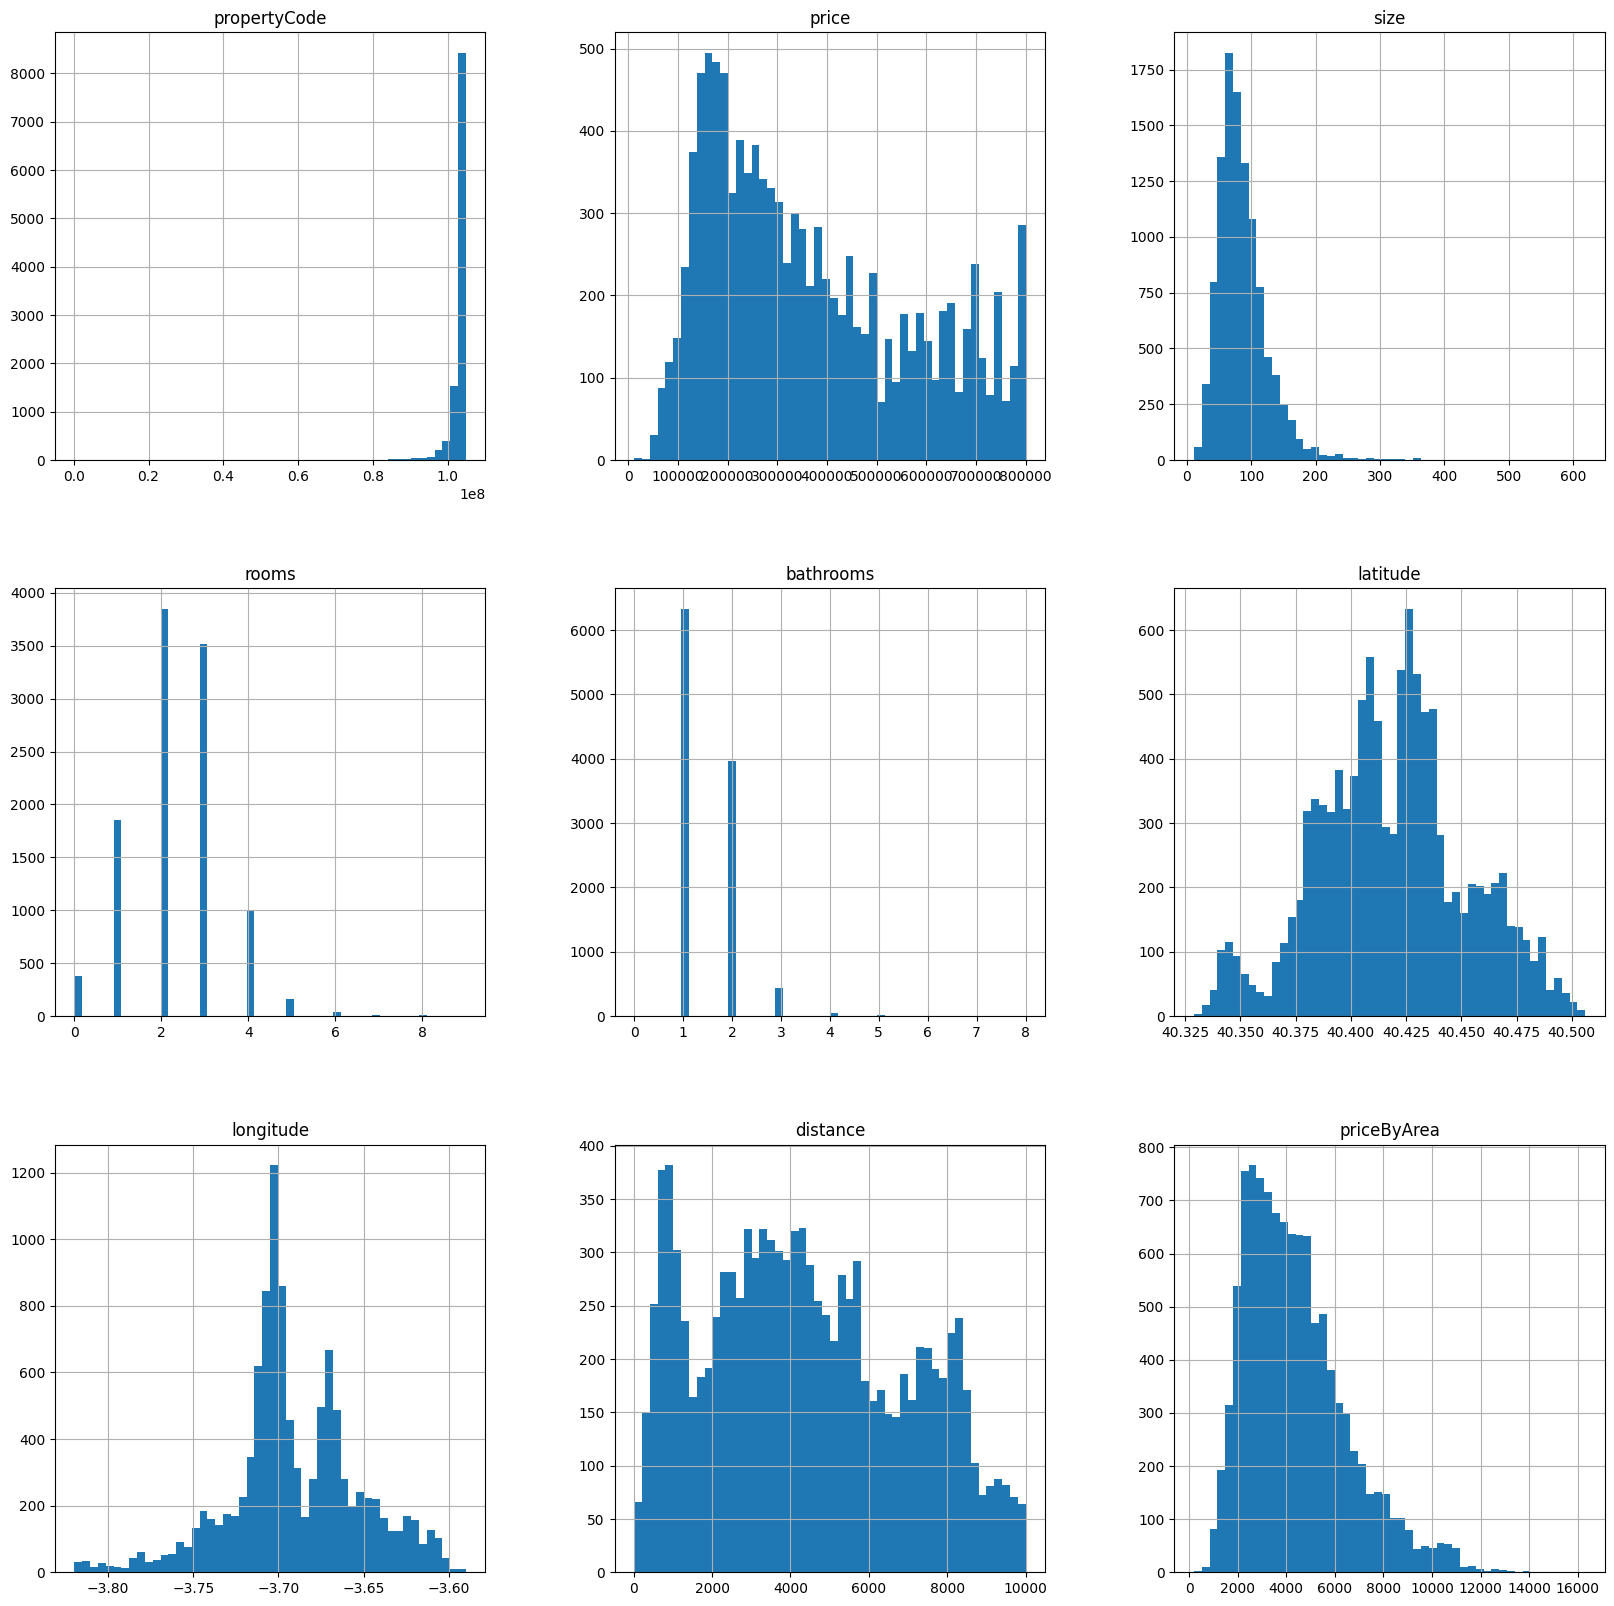

In [10]:
merged_df = merged_df[merged_df['province']=='Madrid']
merged_df = merged_df[merged_df['price']<=800000]
merged_df.hist(bins=50, figsize=(20, 20))
plt.show()

### Gráfico datos tras procesar

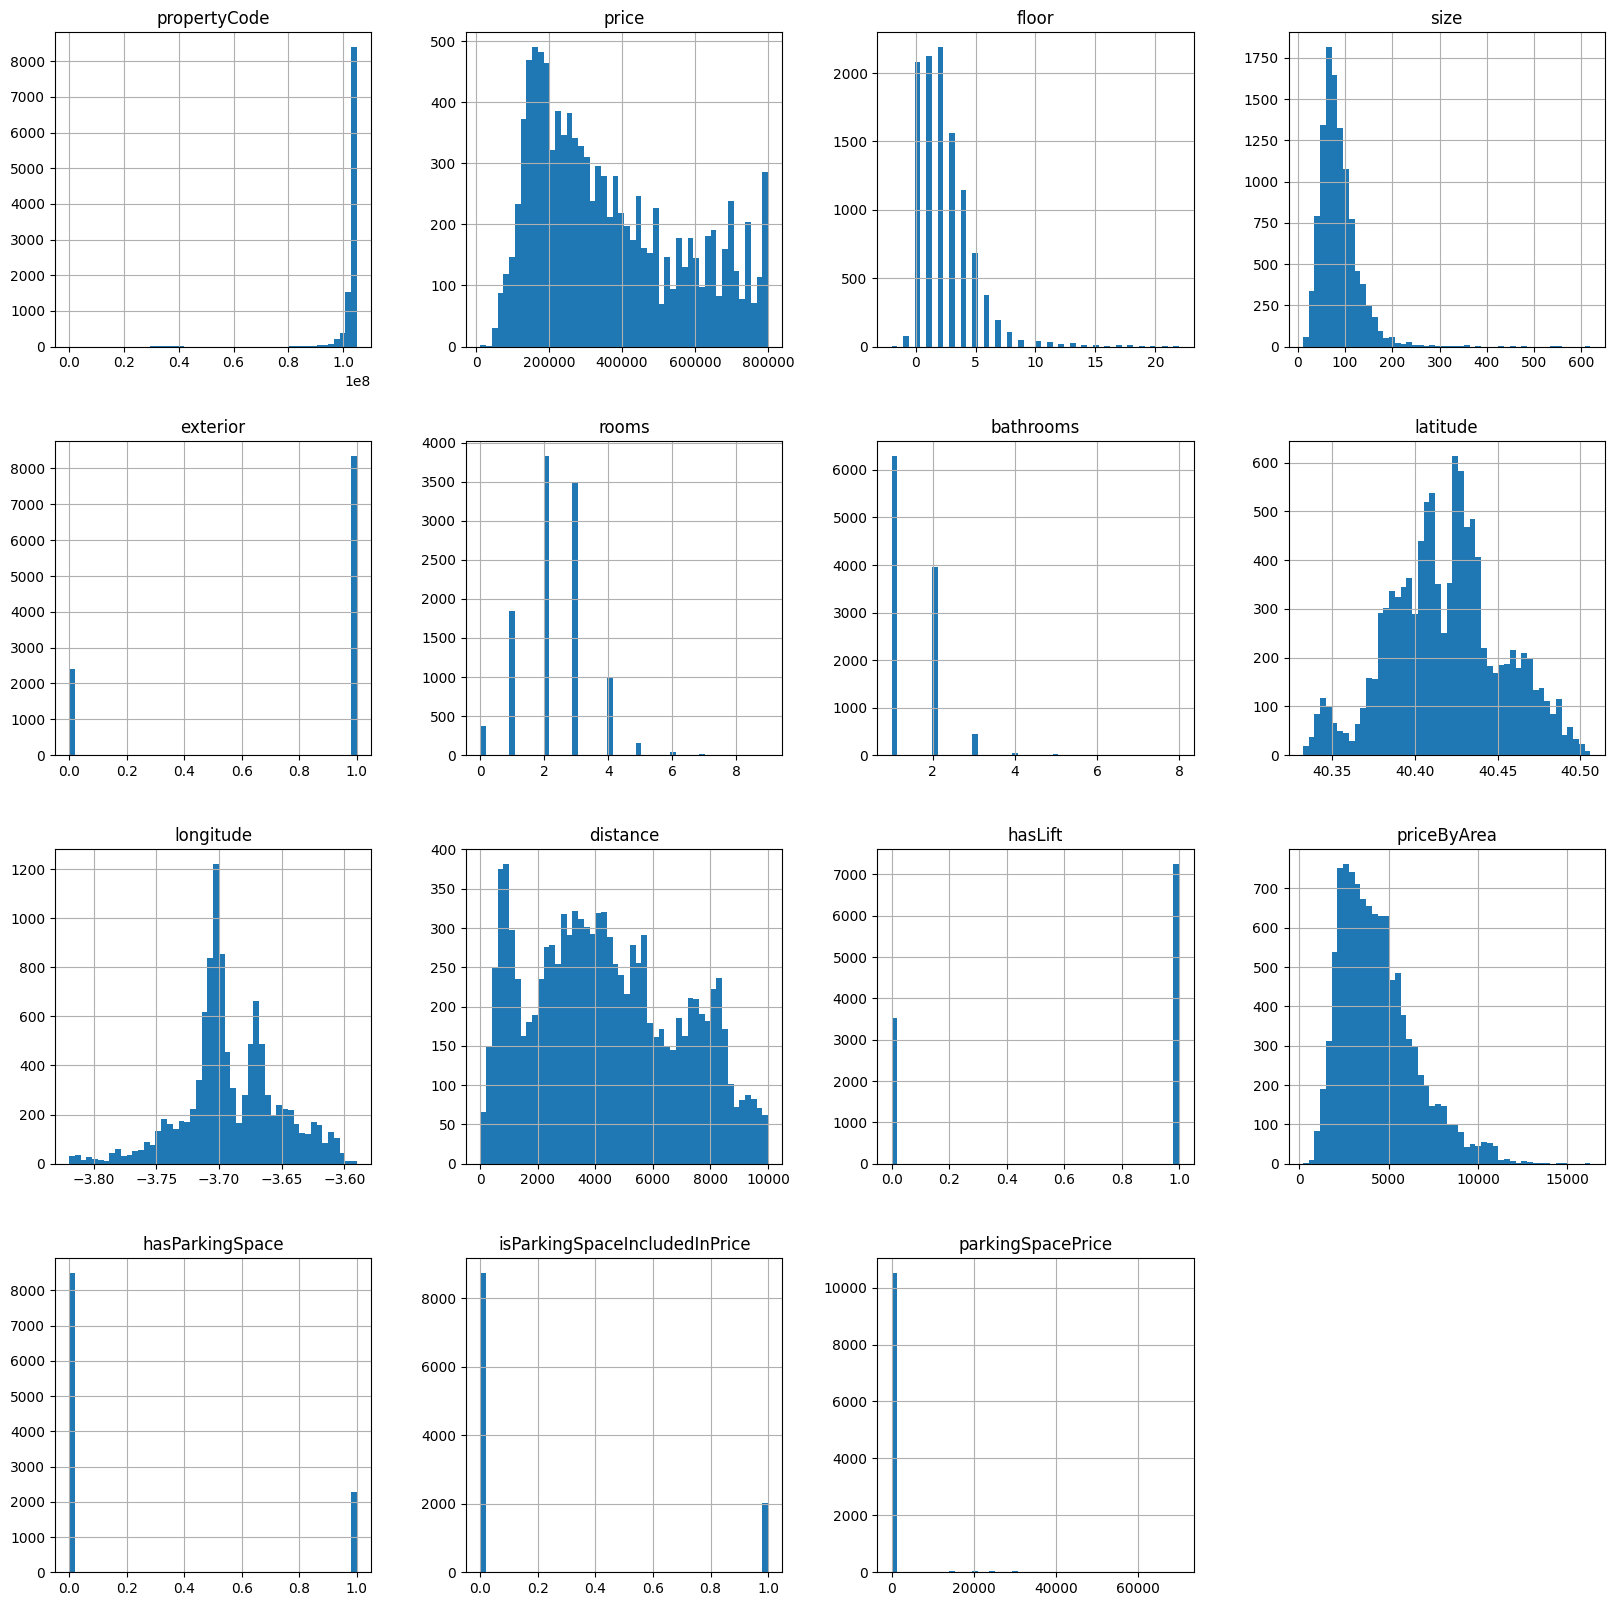

In [11]:
processed_df = processed_df[processed_df['province']=='Madrid']
processed_df = processed_df[processed_df['price']<=800000]

processed_df.hist(bins=50, figsize=(20, 20))
plt.show()

### Gráfico datos tras procesar y feature engineering

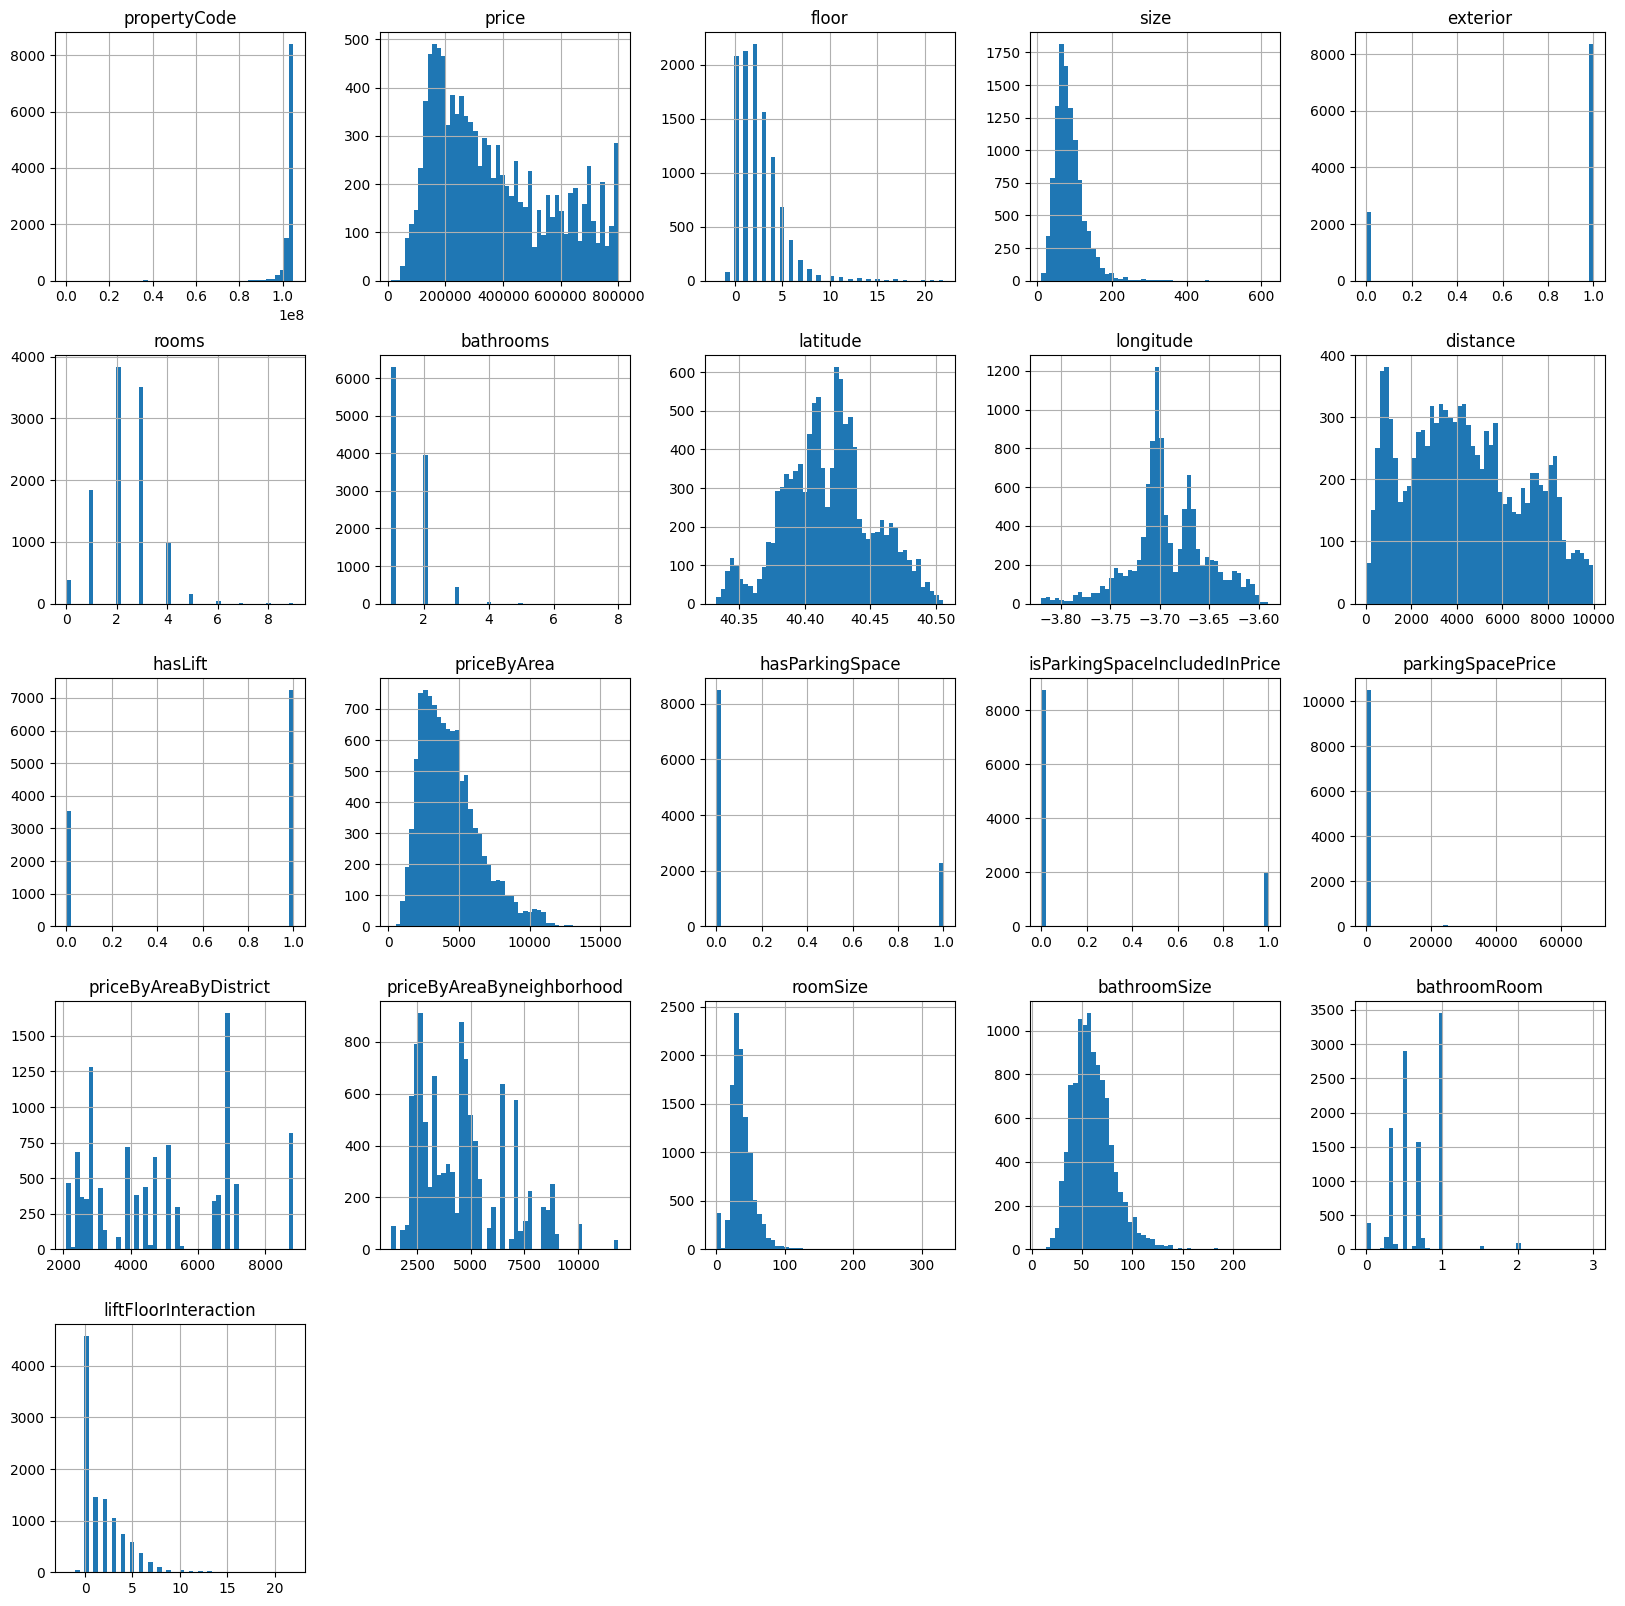

In [12]:
feature_engineering_df = feature_engineering_df[feature_engineering_df['province']=='Madrid']
feature_engineering_df = feature_engineering_df[feature_engineering_df['price']<=800000]
feature_engineering_df.hist(bins=50, figsize=(20, 20))
plt.show()

### Funciones de ML

In [29]:
def score_dataset_LinearRegression(X_train, X_valid, y_train, y_valid):
    # Crear un modelo RandomForestRegressor con 10 árboles
    model = LinearRegression()
    
    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(X_valid)
    
    # Calcular el error absoluto medio (MAE)
    mae = mean_absolute_error(y_valid, y_pred)
    
    # Calcular el error cuadrático medio (RMSE)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    print("Resultados de Modelo LinearRegression")
    print(f"Cantidad de valores {(X_train.shape)}")
    # Devolver los resultados del MAE y RMSE
    return f'RMSE: {rmse}\nMAE: {mae}\n'

def score_dataset_RandomForestRegressor(X_train, X_valid, y_train, y_valid):
    # Crear un modelo RandomForestRegressor con 10 árboles
    model = RandomForestRegressor(n_estimators=10,random_state=42)
    
    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(X_valid)
    
    # Calcular el error absoluto medio (MAE)
    mae = mean_absolute_error(y_valid, y_pred)
    
    # Calcular el error cuadrático medio (RMSE)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    print("Resultados de Modelo RandomForestRegressor")
    print(f"Cantidad de valores {(X_train.shape)}")
    # Devolver los resultados del MAE y RMSE
    return f'RMSE: {rmse}\nMAE: {mae}\n'

def score_dataset_RandomForestRegressor_w_OneHotEncoder(X_train, X_valid, y_train, y_valid):
    # Definir características categóricas y numéricas
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    numeric_features = ['priceByArea', 'floor', 'size','exterior' , 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 
                        'priceByAreaByDistrict', 'priceByAreaByneighborhood', 'roomSize', 'bathroomSize', 
                        'bathroomRoom', 'liftFloorInteraction']

    # Define transformaciones para las variables categóricas usando OneHotEncoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Define transformaciones para las variables numéricas
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Crear el preprocesador de columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', RandomForestRegressor(n_estimators=10, random_state=42))])

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(X_valid)
    
    # Calcular el error absoluto medio (MAE)
    mae = mean_absolute_error(y_valid, y_pred)
    
    # Calcular el error cuadrático medio (RMSE)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    print("Resultados de Modelo RandomForestRegressor con OneHotEncoder")
    print(f"Cantidad de valores {(X_train.shape)}")
    # Devolver los resultados del MAE y RMSE
    return f'RMSE: {rmse}\nMAE: {mae}\n'

def score_dataset_RandomForestRegressor_w_TargetEncoder(X_train, X_valid, y_train, y_valid):
    # Define transformaciones para las variables categóricas usando TargetEncoder
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    categorical_transformer = ce.TargetEncoder(cols=categorical_features, smoothing=0.5)

    # Define transformaciones para las variables numéricas
    numeric_features = ['priceByArea', 'floor', 'size','exterior' , 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift','hasParkingSpace','isParkingSpaceIncludedInPrice', 'parkingSpacePrice','priceByAreaByDistrict','priceByAreaByneighborhood', 
                        'roomSize', 'bathroomSize', 'bathroomRoom','liftFloorInteraction']
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Aplicar TargetEncoder manualmente
    X_train_categorical = categorical_transformer.fit_transform(X_train[categorical_features], y_train)
    X_valid_categorical = categorical_transformer.transform(X_valid[categorical_features])

    # Convertir a objetos después de aplicar el TargetEncoder
    X_train_categorical = X_train_categorical.infer_objects(copy=False)
    X_valid_categorical = X_valid_categorical.infer_objects(copy=False)

    # Aplicar transformaciones numéricas
    X_train_numeric = numeric_transformer.fit_transform(X_train[numeric_features])
    X_valid_numeric = numeric_transformer.transform(X_valid[numeric_features])

    # Combinar características transformadas
    X_train_transformed = np.hstack((X_train_numeric, X_train_categorical))
    X_valid_transformed = np.hstack((X_valid_numeric, X_valid_categorical))

    # Crear un modelo RandomForestRegressor con 10 árboles
    model = RandomForestRegressor(n_estimators=10, random_state=42)
    
    # Entrenar el modelo con los datos de entrenamiento transformados
    model.fit(X_train_transformed, y_train)
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(X_valid_transformed)
    
    # Calcular el error absoluto medio (MAE)
    mae = mean_absolute_error(y_valid, y_pred)
    
    # Calcular el error cuadrático medio (RMSE)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    print("Resultados de Modelo RandomForestRegressor con TargetEncoder")
    print(f"Cantidad de valores {(X_train_transformed.shape)}")
    # Devolver los resultados del MAE y RMSE
    return f'RMSE: {rmse}\nMAE: {mae}\n'

def score_dataset_GradientBoostingRegressor(X_train, X_valid, y_train, y_valid):
    # Crear un modelo GradientBoostingRegressor con parámetros por defecto
    model = GradientBoostingRegressor(random_state=42)
    
    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(X_valid)
    
    # Calcular el error absoluto medio (MAE)
    mae = mean_absolute_error(y_valid, y_pred)
    
    # Calcular el error cuadrático medio (RMSE)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    print("Resultados de Modelo GradientBoostingRegressor")
    print(f"Cantidad de valores {(X_train.shape)}")
    # Devolver los resultados del MAE y RMSE
    return f'RMSE: {rmse}\nMAE: {mae}\n'

def score_dataset_GradientBoostingRegressor_w_OneHotEncoder(X_train, X_valid, y_train, y_valid):
    # Define transformaciones para las variables categóricas
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    categorical_transformer = Pipeline(steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Define transformaciones para las variables numéricas
    numeric_features = ['priceByArea', 'floor', 'size', 'exterior' ,'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift','hasParkingSpace','isParkingSpaceIncludedInPrice', 'parkingSpacePrice','priceByAreaByDistrict','priceByAreaByneighborhood', 
                        'roomSize', 'bathroomSize', 'bathroomRoom','liftFloorInteraction']
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor())])

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(X_valid)
    
    # Calcular el error absoluto medio (MAE)
    mae = mean_absolute_error(y_valid, y_pred)
    
    # Calcular el error cuadrático medio (RMSE)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    print("Resultados de Modelo GradientBoostingRegressor_w_object")
    print(f"Cantidad de valores {(X_train.shape)}")
    # Devolver los resultados del MAE y RMSE
    return f'RMSE: {rmse}\nMAE: {mae}\n'

def score_dataset_GradientBoostingRegressor_w_TargetEncoder(X_train, X_valid, y_train, y_valid):
    # Define transformaciones para las variables categóricas usando TargetEncoder
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    categorical_transformer = ce.TargetEncoder(cols=categorical_features, smoothing=0.5)

    # Define transformaciones para las variables numéricas
    numeric_features = ['priceByArea', 'floor', 'size','exterior' ,'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift','hasParkingSpace','isParkingSpaceIncludedInPrice', 'parkingSpacePrice','priceByAreaByDistrict','priceByAreaByneighborhood', 
                        'roomSize', 'bathroomSize', 'bathroomRoom','liftFloorInteraction']
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Aplicar TargetEncoder manualmente
    X_train_categorical = categorical_transformer.fit_transform(X_train[categorical_features], y_train)
    X_valid_categorical = categorical_transformer.transform(X_valid[categorical_features])

    # Aplicar transformaciones numéricas
    X_train_numeric = numeric_transformer.fit_transform(X_train[numeric_features])
    X_valid_numeric = numeric_transformer.transform(X_valid[numeric_features])

    # Combinar características transformadas
    X_train_transformed = np.hstack((X_train_numeric, X_train_categorical))
    X_valid_transformed = np.hstack((X_valid_numeric, X_valid_categorical))

    # Entrenar el modelo con los datos de entrenamiento transformados
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train_transformed, y_train)
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(X_valid_transformed)
    
    # Calcular el error absoluto medio (MAE)
    mae = mean_absolute_error(y_valid, y_pred)
    
    # Calcular el error cuadrático medio (RMSE)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    print("Resultados de Modelo GradientBoostingRegressor con TargetEncoder")
    print(f"Cantidad de valores {(X_train_transformed.shape)}")
    # Devolver los resultados del MAE y RMSE
    return f'RMSE: {rmse}\nMAE: {mae}\n'

def score_dataset_XGBRegressor(X_train, X_valid, y_train, y_valid):
    # Definir las características categóricas y numéricas
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    numeric_features = ['priceByArea', 'floor', 'size', 'exterior', 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 'priceByAreaByDistrict', 'priceByAreaByneighborhood', 
                        'roomSize', 'bathroomSize', 'bathroomRoom', 'liftFloorInteraction']
    
    # Crear transformaciones para las variables numéricas y categóricas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Aplicar transformaciones
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_valid_transformed = preprocessor.transform(X_valid)

    # Convertir a DMatrix
    dtrain = xgb.DMatrix(X_train_transformed, label=y_train)
    dvalid = xgb.DMatrix(X_valid_transformed, label=y_valid)

    # Entrenar el modelo con los datos de entrenamiento transformados
    model = xgb.train(
        params={
            'objective': 'reg:squarederror',
            'max_depth': 6,
            'eta': 0.1,
            'seed': 42
        },
        dtrain=dtrain,
        num_boost_round=100
    )
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(dvalid)
    
    # Calcular el error absoluto medio (MAE)
    mae = mean_absolute_error(y_valid, y_pred)
    
    # Calcular el error cuadrático medio (RMSE)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    print("Resultados de Modelo XGBRegressor")
    print(f"Cantidad de valores {(X_train_transformed.shape)}")
    # Devolver los resultados del MAE y RMSE
    return f'RMSE: {rmse}\nMAE: {mae}\n'

def score_dataset_XGBRegressor_w_OneHotEncoder(X_train, X_valid, y_train, y_valid):
    # Definir las características categóricas y numéricas
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    numeric_features = ['priceByArea', 'floor', 'size', 'exterior', 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 'priceByAreaByDistrict', 'priceByAreaByneighborhood', 
                        'roomSize', 'bathroomSize', 'bathroomRoom', 'liftFloorInteraction']
    
    # Crear transformaciones para las variables numéricas y categóricas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Aplicar transformaciones
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_valid_transformed = preprocessor.transform(X_valid)

    # Entrenar el modelo con los datos de entrenamiento transformados
    model = xgb.XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    model.fit(X_train_transformed, y_train)
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(X_valid_transformed)
    
    # Calcular el error absoluto medio (MAE)
    mae = mean_absolute_error(y_valid, y_pred)
    
    # Calcular el error cuadrático medio (RMSE)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    print("Resultados de Modelo XGBRegressor con OneHotEncoder")
    print(f"Cantidad de valores {(X_train_transformed.shape)}")
    # Devolver los resultados del MAE y RMSE
    return f'RMSE: {rmse}\nMAE: {mae}\n'

def score_dataset_XGBRegressor_w_TargetEncoder(X_train, X_valid, y_train, y_valid):
    # Define transformaciones para las variables categóricas usando TargetEncoder
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    categorical_transformer = ce.TargetEncoder(cols=categorical_features, smoothing=0.5)

    # Define transformaciones para las variables numéricas
    numeric_features = ['priceByArea', 'floor', 'size', 'exterior', 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 'priceByAreaByDistrict', 'priceByAreaByneighborhood', 
                        'roomSize', 'bathroomSize', 'bathroomRoom', 'liftFloorInteraction']
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Aplicar TargetEncoder manualmente
    X_train_categorical = categorical_transformer.fit_transform(X_train[categorical_features], y_train)
    X_valid_categorical = categorical_transformer.transform(X_valid[categorical_features])

    # Aplicar transformaciones numéricas
    X_train_numeric = numeric_transformer.fit_transform(X_train[numeric_features])
    X_valid_numeric = numeric_transformer.transform(X_valid[numeric_features])

    # Combinar características transformadas
    X_train_transformed = np.hstack((X_train_numeric, X_train_categorical))
    X_valid_transformed = np.hstack((X_valid_numeric, X_valid_categorical))

    # Entrenar el modelo con los datos de entrenamiento transformados
    model = xgb.XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    model.fit(X_train_transformed, y_train)
    
    # Hacer predicciones en el conjunto de validación
    y_pred = model.predict(X_valid_transformed)
    
    # Calcular el error absoluto medio (MAE)
    mae = mean_absolute_error(y_valid, y_pred)
    
    # Calcular el error cuadrático medio (RMSE)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    print("Resultados de Modelo XGBRegressor con TargetEncoder")
    print(f"Cantidad de valores {(X_train_transformed.shape)}")
    # Devolver los resultados del MAE y RMSE
    return f'RMSE: {rmse}\nMAE: {mae}\n'

### ML: Datos sin procesar y eliminando Nan

In [575]:
# Load the data
data = merged_df[merged_df['province']=='Madrid']
data = merged_df[merged_df['price']<=800000]
data = merged_df.dropna()
# Select target
y =data['price']
melb_predictors = data.drop(['propertyCode','price','Month','province'], axis=1) 
X = melb_predictors.select_dtypes(exclude=['object'])
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)

# Correr modelo de LinearRegression
print(score_dataset_LinearRegression(X_train, X_valid, y_train, y_valid))
# Correr modelo de RandomForestRegressor
print(score_dataset_RandomForestRegressor(X_train, X_valid, y_train, y_valid))
# Correr modelo de GradientBoostingRegressor
print(score_dataset_GradientBoostingRegressor(X_train, X_valid, y_train, y_valid))



Resultados de Modelo LinearRegression
Cantidad de valores (2600, 7)
RMSE: 337045.3936265594
MAE: 224721.0485749709

Resultados de Modelo RandomForestRegressor
Cantidad de valores (2600, 7)
RMSE: 124656.99454622409
MAE: 30925.73625192013

Resultados de Modelo GradientBoostingRegressor
Cantidad de valores (2600, 7)
RMSE: 85441.09009683532
MAE: 46099.03375448853



### ML: Datos tras procesar

In [576]:
# Load the data
data = processed_df[processed_df['province']=='Madrid']
data = processed_df[processed_df['price']<=800000]
# Select target
y =data['price']
melb_predictors = data.drop(['propertyCode','price','Month','province'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)

# Correr modelo de LinearRegression sin variables categóricas
print(score_dataset_LinearRegression(X_train, X_valid, y_train, y_valid))
# Correr modelo de RandomForestRegressor sin variables categóricas
print(score_dataset_RandomForestRegressor(X_train, X_valid, y_train, y_valid))
# Correr modelo de GradientBoostingRegressor sin variables categóricas
print(score_dataset_GradientBoostingRegressor(X_train, X_valid, y_train, y_valid))

Resultados de Modelo LinearRegression
Cantidad de valores (8588, 13)
RMSE: 65466.03190162114
MAE: 44005.72785132495

Resultados de Modelo RandomForestRegressor
Cantidad de valores (8588, 13)
RMSE: 9755.73565280672
MAE: 4609.202188081937

Resultados de Modelo GradientBoostingRegressor
Cantidad de valores (8588, 13)
RMSE: 17114.617329713124
MAE: 12151.131045336142



### ML: Datos tras procesar y feature engineering

In [577]:
# Load the data
data = feature_engineering_df[feature_engineering_df['province']=='Madrid']
data = feature_engineering_df[feature_engineering_df['price']<=800000]
# Select target
y =data['price']
melb_predictors = data.drop(['propertyCode','price','Month','province'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)

# Correr modelo de LinearRegression sin variables categóricas
print(score_dataset_LinearRegression(X_train, X_valid, y_train, y_valid))
# Correr modelo de RandomForestRegressor sin variables categóricas
print(score_dataset_RandomForestRegressor(X_train, X_valid, y_train, y_valid))
# Correr modelo de GradientBoostingRegressor sin variables categóricas
print(score_dataset_GradientBoostingRegressor(X_train, X_valid, y_train, y_valid))

data = feature_engineering_df[feature_engineering_df['province']=='Madrid']
data = feature_engineering_df[feature_engineering_df['price']<=800000]
X=melb_predictors = data.drop(['propertyCode','price','Month','province'], axis=1)

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)

# Correr el modelo RandomForestRegressor_w_OneHotEncoder con variables categóricas
print(score_dataset_RandomForestRegressor_w_OneHotEncoder(X_train, X_valid, y_train, y_valid))

# Correr modelo de score_dataset_RandomForestRegressor_w_TargetEncoder
print(score_dataset_RandomForestRegressor_w_TargetEncoder(X_train, X_valid, y_train, y_valid))

# Correr el modelo GradientBoostingRegressor_w_OneHotEncoder con variables categóricas
print(score_dataset_GradientBoostingRegressor_w_OneHotEncoder(X_train, X_valid, y_train, y_valid))

# Correr el modelo GradientBoostingRegressor_w_TargetEncoder con variables categóricas
print(score_dataset_GradientBoostingRegressor_w_TargetEncoder(X_train, X_valid, y_train, y_valid))

Resultados de Modelo LinearRegression
Cantidad de valores (8588, 19)
RMSE: 64717.77309466635
MAE: 42629.32884414522

Resultados de Modelo RandomForestRegressor
Cantidad de valores (8588, 19)
RMSE: 11387.41826221761
MAE: 5743.400465549348

Resultados de Modelo GradientBoostingRegressor
Cantidad de valores (8588, 19)
RMSE: 17868.19810776348
MAE: 12820.457566799672

Resultados de Modelo RandomForestRegressor con OneHotEncoder
Cantidad de valores (8588, 23)
RMSE: 11754.294908867661
MAE: 5798.6335661080075

Resultados de Modelo RandomForestRegressor con TargetEncoder
Cantidad de valores (8588, 23)
RMSE: 12924.895043814011
MAE: 6375.316247672254

Resultados de Modelo GradientBoostingRegressor_w_object
Cantidad de valores (8588, 23)
RMSE: 18012.15220783707
MAE: 12975.132678738853

Resultados de Modelo GradientBoostingRegressor con TargetEncoder
Cantidad de valores (8588, 23)
RMSE: 17584.998398984637
MAE: 12230.183799568342



### Optimizar Modelo de RandomForestRegressor con OneHotEncoder

In [590]:

def optimize_random_forest_with_onehot(data):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province'], axis=1)
    y = data['price']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    categorical_transformer = TargetEncoder()

    numeric_features = ['priceByArea', 'floor', 'size', 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 
                        'priceByAreaByDistrict', 'priceByAreaByneighborhood', 'roomSize', 'bathroomSize', 
                        'bathroomRoom', 'liftFloorInteraction']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', RandomForestRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'regressor__n_estimators': randint(100, 1000),
        'regressor__max_features': ['sqrt', 'log2'],
        'regressor__max_depth': randint(10, 50),
        'regressor__min_samples_split': randint(2, 10),
        'regressor__min_samples_leaf': randint(1, 4)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, y_pred)

    # Imprimir resultados
    print("Mejores hiperparámetros:", random_search.best_params_)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)

    return best_model, random_search.best_params_, rmse, mae

best_model, best_params_RFR, rmse, mae = optimize_random_forest_with_onehot(feature_engineering_df)


Mejores hiperparámetros: {'regressor__max_depth': 18, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 700}
Mean Squared Error: 1355288496.6096158
Root Mean Squared Error: 36814.243121509586
Mean Absolute Error: 22564.148302881287


### Optimizar Modelo de GradientBoostingRegressor con TargetEncoder

In [604]:

def optimize_gradient_boosting_with_TargetEncoder(data):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    categorical_transformer = TargetEncoder()

    numeric_features = ['priceByArea', 'floor', 'size', 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 
                        'priceByAreaByDistrict', 'priceByAreaByneighborhood', 'roomSize', 'bathroomSize', 
                        'bathroomRoom', 'liftFloorInteraction']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'regressor__n_estimators': randint(100, 1000),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__max_depth': randint(3, 10),
        'regressor__min_samples_split': randint(2, 20),
        'regressor__min_samples_leaf': randint(1, 10),
        'regressor__subsample': uniform(0.7, 0.3)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid.drop(columns='propertyCode'))
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, y_pred)

    # Imprimir resultados
    print("Mejores hiperparámetros:", random_search.best_params_)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    merged_df_Difference = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    merged_df_Difference['Difference'] = merged_df_Difference['price'] - merged_df_Difference['Predicted_Price']

    return best_model, random_search.best_params_, rmse, mae, merged_df_Difference

# Ejemplo de uso
best_model, best_params_GBR, rmse, mae, merged_df_Difference = optimize_gradient_boosting_with_TargetEncoder(feature_engineering_df)


Mejores hiperparámetros: {'regressor__learning_rate': 0.09503117489824894, 'regressor__max_depth': 8, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 19, 'regressor__n_estimators': 829, 'regressor__subsample': 0.8349262400109296}
Mean Squared Error: 69767369.00987169
Root Mean Squared Error: 8352.6863349387
Mean Absolute Error: 4246.35183154576


### Evaluar si tiene ovefitting

In [626]:
def optimize_gradient_boosting_with_TargetEncoder_overfitting(data, best_params):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    categorical_transformer = TargetEncoder()

    numeric_features = ['priceByArea', 'floor', 'size', 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 
                        'priceByAreaByDistrict', 'priceByAreaByneighborhood', 'roomSize', 'bathroomSize', 
                        'bathroomRoom', 'liftFloorInteraction']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Configura el modelo con los mejores hiperparámetros
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor(random_state=42, **best_params))])

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train.drop(columns='propertyCode'), y_train)

    # Evalúa el modelo en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train.drop(columns='propertyCode'))
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    # Evalúa el modelo en el conjunto de validación
    y_valid_pred = model.predict(X_valid.drop(columns='propertyCode'))
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    valid_rmse = np.sqrt(valid_mse)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)

    # Calcular la variación
    mse_variation = (valid_mse / train_mse) - 1
    rmse_variation = (valid_rmse / train_rmse) - 1
    mae_variation = (valid_mae / train_mae) - 1

    # Imprimir resultados
    print("Mejores hiperparámetros:", best_params)
    print("\nRendimiento en el conjunto de entrenamiento:")
    print("Mean Squared Error:", train_mse)
    print("Root Mean Squared Error:", train_rmse)
    print("Mean Absolute Error:", train_mae)
    print("\nRendimiento en el conjunto de validación:")
    print("Mean Squared Error:", valid_mse)
    print("Root Mean Squared Error:", valid_rmse)
    print("Mean Absolute Error:", valid_mae)
    print("\nVariación (Validación / Entrenamiento) - 1:")
    print("MSE Variation:", mse_variation)
    print("RMSE Variation:", rmse_variation)
    print("MAE Variation:", mae_variation)

# Ejemplo de uso
clean_params = {key.replace('regressor__', ''): value for key, value in best_params_GBR.items()}
optimize_gradient_boosting_with_TargetEncoder_overfitting(feature_engineering_df, clean_params)

Mejores hiperparámetros: {'learning_rate': 0.09503117489824894, 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 19, 'n_estimators': 829, 'subsample': 0.8349262400109296}

Rendimiento en el conjunto de entrenamiento:
Mean Squared Error: 521502.07236602745
Root Mean Squared Error: 722.1510038530913
Mean Absolute Error: 522.4672954499462

Rendimiento en el conjunto de validación:
Mean Squared Error: 69767369.00987169
Root Mean Squared Error: 8352.6863349387
Mean Absolute Error: 4246.35183154576

Variación (Validación / Entrenamiento) - 1:
MSE Variation: 132.78157577273052
RMSE Variation: 10.566398565358645
MAE Variation: 7.127497871208998


### Importancia de las variables

                          Feature  Importance
21                   neighborhood    0.407539
2                            size    0.197393
0                     priceByArea    0.192727
4                       bathrooms    0.157484
15                   bathroomSize    0.043780
6                        latitude    0.000179
14                       roomSize    0.000165
13      priceByAreaByneighborhood    0.000151
7                       longitude    0.000129
5                        distance    0.000103
3                           rooms    0.000086
1                           floor    0.000060
17           liftFloorInteraction    0.000050
12          priceByAreaByDistrict    0.000041
20                       district    0.000039
16                   bathroomRoom    0.000028
11              parkingSpacePrice    0.000023
10  isParkingSpaceIncludedInPrice    0.000006
19                         status    0.000005
18                   propertyType    0.000005
9                 hasParkingSpace 

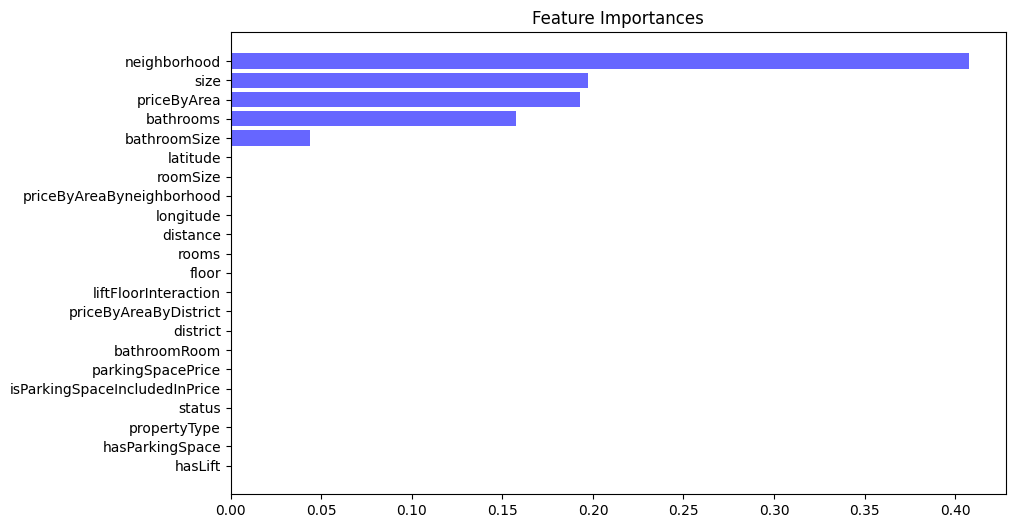

In [627]:
# Obtener importancia de características
feature_names = numeric_features + categorical_features
importances = best_model.named_steps['regressor'].feature_importances_

# Crear un DataFrame para las importancias
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Imprimir las importancias de características
print(feature_importances_df)

# Plot de la importancia de las características
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='blue', alpha=0.6)
plt.gca().invert_yaxis()
plt.show()

### Gráfico comparación valor real vs predicho

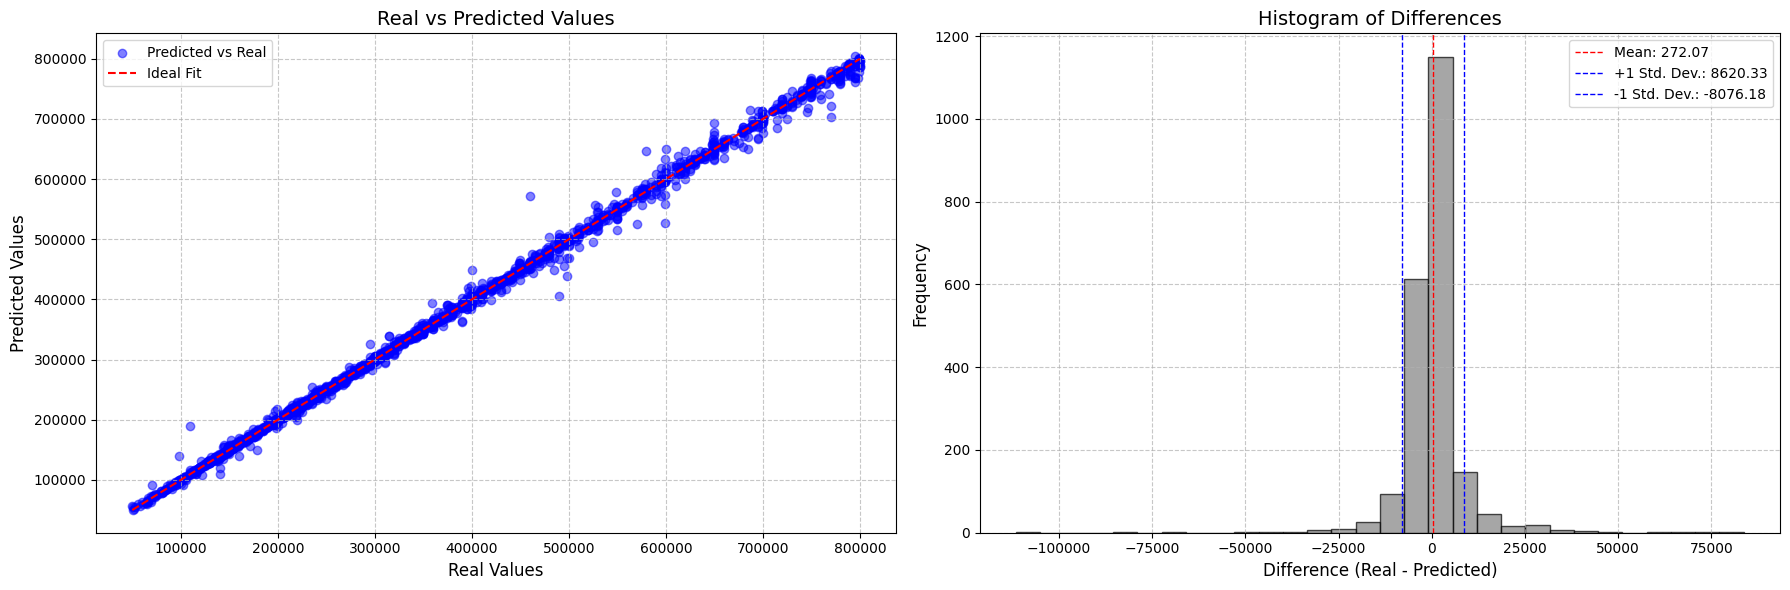

In [613]:
y_pred = merged_df_Difference['Predicted_Price']
y_real = merged_df_Difference['price']
differences = merged_df_Difference['Difference']

# Calcular estadísticas de las diferencias
mean_diff = np.mean(differences)
std_diff = np.std(differences)

# Crear una figura con dos subplots: uno para el scatter plot y otro para el histograma
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Real vs Predicted Values
ax[0].set_title('Real vs Predicted Values', fontsize=14)
ax[0].set_xlabel('Real Values', fontsize=12)
ax[0].set_ylabel('Predicted Values', fontsize=12)
sc = ax[0].scatter(y_real, y_pred, color='blue', alpha=0.5, label='Predicted vs Real')
ax[0].plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--', label='Ideal Fit')
ax[0].legend(loc='upper left')
ax[0].grid(True, linestyle='--', alpha=0.7)

# Subplot 2: Histograma de las diferencias
ax[1].set_title('Histogram of Differences', fontsize=14)
ax[1].set_xlabel('Difference (Real - Predicted)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].hist(differences, bins=30, color='gray', alpha=0.7, edgecolor='black')
ax[1].axvline(mean_diff, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_diff:.2f}')
ax[1].axvline(mean_diff + std_diff, color='blue', linestyle='dashed', linewidth=1, label=f'+1 Std. Dev.: {mean_diff + std_diff:.2f}')
ax[1].axvline(mean_diff - std_diff, color='blue', linestyle='dashed', linewidth=1, label=f'-1 Std. Dev.: {mean_diff - std_diff:.2f}')
ax[1].legend(loc='upper right')
ax[1].grid(True, linestyle='--', alpha=0.7)

# Mostrar la figura
plt.tight_layout()
plt.show()


In [628]:
merged_df_Difference.sort_values(by='Difference',ascending=False).head(15)

,propertyCode,Predicted_Price,price,Difference
2076,104877619,406335.534109,490000.0,83664.465891
1640,104747703,527481.931638,599000.0,71518.068362
1288,104293903,702863.890878,770000.0,67136.109122
1323,102970976,438563.197432,498000.0,59436.802568
214,104170446,721861.212817,770000.0,48138.787183
2050,103450939,526241.973772,570000.0,43758.026228
461,103755026,559116.288221,598900.0,39783.711779
1832,98270519,456386.291900,495000.0,38613.708100
1488,104858787,449746.124449,485000.0,35253.875551
846,101108633,514957.984693,550000.0,35042.015307


In [629]:
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from category_encoders import TargetEncoder

def tune_gradient_boosting(data):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    categorical_transformer = TargetEncoder()

    numeric_features = ['priceByArea', 'floor', 'size', 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 
                        'priceByAreaByDistrict', 'priceByAreaByneighborhood', 'roomSize', 'bathroomSize', 
                        'bathroomRoom', 'liftFloorInteraction']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Define el modelo
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda en cuadrícula
    param_grid = {
        'regressor__n_estimators': [100, 200, 500],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_samples_split': [5, 10, 20],
        'regressor__min_samples_leaf': [2, 5, 10],
        'regressor__subsample': [0.7, 0.85, 1.0]
    }

    # Aplica la búsqueda en cuadrícula de hiperparámetros
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = grid_search.best_estimator_

    # Evalúa el modelo en el conjunto de entrenamiento
    y_train_pred = best_model.predict(X_train.drop(columns='propertyCode'))
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    # Evalúa el modelo en el conjunto de validación
    y_valid_pred = best_model.predict(X_valid.drop(columns='propertyCode'))
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    valid_rmse = np.sqrt(valid_mse)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)

    # Calcular la variación
    mse_variation = (valid_mse / train_mse) - 1
    rmse_variation = (valid_rmse / train_rmse) - 1
    mae_variation = (valid_mae / train_mae) - 1

    # Imprimir resultados
    print("Mejores hiperparámetros:", grid_search.best_params_)
    print("\nRendimiento en el conjunto de entrenamiento:")
    print("Mean Squared Error:", train_mse)
    print("Root Mean Squared Error:", train_rmse)
    print("Mean Absolute Error:", train_mae)
    print("\nRendimiento en el conjunto de validación:")
    print("Mean Squared Error:", valid_mse)
    print("Root Mean Squared Error:", valid_rmse)
    print("Mean Absolute Error:", valid_mae)
    print("\nVariación (Validación / Entrenamiento) - 1:")
    print("MSE Variation:", mse_variation)
    print("RMSE Variation:", rmse_variation)
    print("MAE Variation:", mae_variation)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Pr<edicted_Price': y_valid_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    tune_merged_df_Difference = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    tune_merged_df_Difference['Difference'] = tune_merged_df_Difference['price'] - tune_merged_df_Difference['Predicted_Price']

    return best_model, grid_search.best_params_, valid_rmse, valid_mae, tune_merged_df_Difference

best_model, best_params, valid_rmse, valid_mae, tune_merged_df_Difference = tune_gradient_boosting(feature_engineering_df)

# Imprimir el DataFrame combinado
print(tune_merged_df_Difference.head())


Mejores hiperparámetros: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 20, 'regressor__n_estimators': 500, 'regressor__subsample': 0.7}

Rendimiento en el conjunto de entrenamiento:
Mean Squared Error: 6534147.833970407
Root Mean Squared Error: 2556.197925429564
Mean Absolute Error: 1870.0555753747308

Rendimiento en el conjunto de validación:
Mean Squared Error: 64381593.64400921
Root Mean Squared Error: 8023.814158117647
Mean Absolute Error: 4180.394949821477

Variación (Validación / Entrenamiento) - 1:
MSE Variation: 8.853097187256077
RMSE Variation: 2.1389643494719843
MAE Variation: 1.235438884742123
   propertyCode  Predicted_Price     price   Difference
0     104282955    181113.775729  179000.0 -2113.775729
1     103968199    288559.549702  288125.0  -434.549702
2     102924220    765263.238712  760000.0 -5263.238712
3     103164753    316644.175728  315000.0 -1644.175728
4     103544962    297067.

                          Feature  Importance
21                   neighborhood    0.404881
2                            size    0.217984
0                     priceByArea    0.195243
4                       bathrooms    0.150367
15                   bathroomSize    0.030611
7                       longitude    0.000185
14                       roomSize    0.000167
6                        latitude    0.000131
5                        distance    0.000115
13      priceByAreaByneighborhood    0.000104
1                           floor    0.000044
20                       district    0.000039
17           liftFloorInteraction    0.000033
12          priceByAreaByDistrict    0.000025
16                   bathroomRoom    0.000021
11              parkingSpacePrice    0.000016
3                           rooms    0.000014
18                   propertyType    0.000007
19                         status    0.000005
10  isParkingSpaceIncludedInPrice    0.000004
9                 hasParkingSpace 

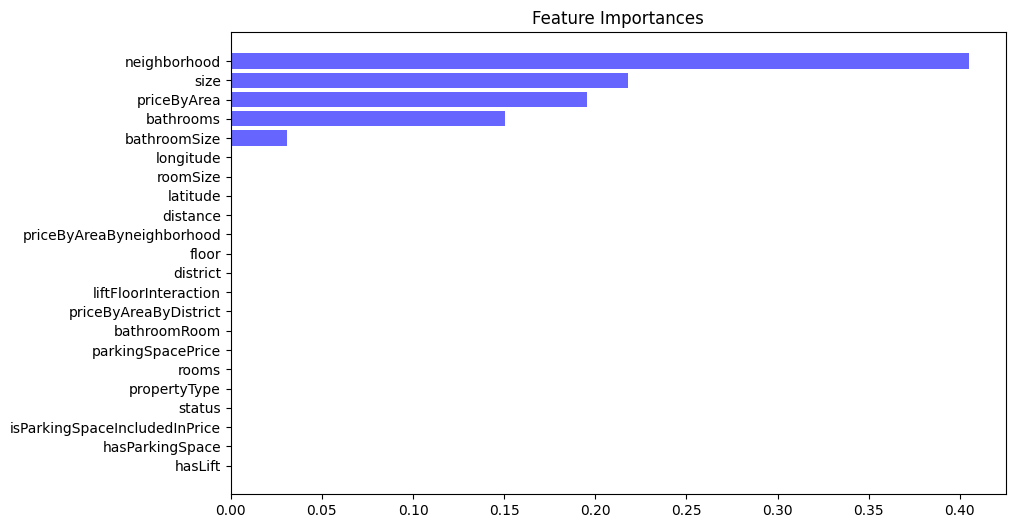

In [630]:
# Obtener importancia de características
feature_names = numeric_features + categorical_features
importances = best_model.named_steps['regressor'].feature_importances_

# Crear un DataFrame para las importancias
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Imprimir las importancias de características
print(feature_importances_df)

# Plot de la importancia de las características
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='blue', alpha=0.6)
plt.gca().invert_yaxis()
plt.show()

In [632]:
def optimize_gradient_boosting_with_TargetEncoder_feature_importance(data):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province','longitude','roomSize','latitude','distance',
                    'priceByAreaByneighborhood','floor','district','liftFloorInteraction','priceByAreaByDistrict',
                    'bathroomRoom','parkingSpacePrice','rooms','propertyType','status','isParkingSpaceIncludedInPrice',
                    'hasParkingSpace','hasLift'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['neighborhood']
    categorical_transformer = TargetEncoder()

    numeric_features = ['priceByArea', 'size','bathrooms','bathroomSize']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'regressor__n_estimators': randint(100, 1000),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__max_depth': randint(3, 10),
        'regressor__min_samples_split': randint(2, 20),
        'regressor__min_samples_leaf': randint(1, 10),
        'regressor__subsample': uniform(0.7, 0.3)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid.drop(columns='propertyCode'))
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, y_pred)

    # Imprimir resultados
    print("Mejores hiperparámetros:", random_search.best_params_)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    feature_importance_merged_df_Difference = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    feature_importance_merged_df_Difference['Difference'] = feature_importance_merged_df_Difference['price'] - feature_importance_merged_df_Difference['Predicted_Price']

    return best_model, random_search.best_params_, rmse, mae, feature_importance_merged_df_Difference

# Ejemplo de uso
best_model, best_params_GBR, rmse, mae, feature_importance_merged_df_Difference = optimize_gradient_boosting_with_TargetEncoder_feature_importance(feature_engineering_df)

Mejores hiperparámetros: {'regressor__learning_rate': 0.1323705789444759, 'regressor__max_depth': 4, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 13, 'regressor__n_estimators': 666, 'regressor__subsample': 0.9949692657420364}
Mean Squared Error: 54956307.163308404
Root Mean Squared Error: 7413.25213137314
Mean Absolute Error: 4854.261124903275


In [635]:
def optimize_gradient_boosting_with_TargetEncoder_overfitting_feature_importance(data, best_params):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province','longitude','roomSize','latitude','distance',
                    'priceByAreaByneighborhood','floor','district','liftFloorInteraction','priceByAreaByDistrict',
                    'bathroomRoom','parkingSpacePrice','rooms','propertyType','status','isParkingSpaceIncludedInPrice',
                    'hasParkingSpace','hasLift'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['neighborhood']
    categorical_transformer = TargetEncoder()

    numeric_features = ['priceByArea', 'size','bathrooms','bathroomSize']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Configura el modelo con los mejores hiperparámetros
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor(random_state=42, **best_params))])

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train.drop(columns='propertyCode'), y_train)

    # Evalúa el modelo en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train.drop(columns='propertyCode'))
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    # Evalúa el modelo en el conjunto de validación
    y_valid_pred = model.predict(X_valid.drop(columns='propertyCode'))
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    valid_rmse = np.sqrt(valid_mse)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)

    # Calcular la variación
    mse_variation = (valid_mse / train_mse) - 1
    rmse_variation = (valid_rmse / train_rmse) - 1
    mae_variation = (valid_mae / train_mae) - 1

    # Imprimir resultados
    print("Mejores hiperparámetros:", best_params)
    print("\nRendimiento en el conjunto de entrenamiento:")
    print("Mean Squared Error:", train_mse)
    print("Root Mean Squared Error:", train_rmse)
    print("Mean Absolute Error:", train_mae)
    print("\nRendimiento en el conjunto de validación:")
    print("Mean Squared Error:", valid_mse)
    print("Root Mean Squared Error:", valid_rmse)
    print("Mean Absolute Error:", valid_mae)
    print("\nVariación (Validación / Entrenamiento) - 1:")
    print("MSE Variation:", mse_variation)
    print("RMSE Variation:", rmse_variation)
    print("MAE Variation:", mae_variation)

# Ejemplo de uso
clean_params = {key.replace('regressor__', ''): value for key, value in best_params_GBR.items()}
optimize_gradient_boosting_with_TargetEncoder_overfitting_feature_importance(feature_engineering_df, clean_params)

Mejores hiperparámetros: {'learning_rate': 0.1323705789444759, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 666, 'subsample': 0.9949692657420364}

Rendimiento en el conjunto de entrenamiento:
Mean Squared Error: 18880212.745132964
Root Mean Squared Error: 4345.136677382308
Mean Absolute Error: 3152.7388575362456

Rendimiento en el conjunto de validación:
Mean Squared Error: 54956307.163308404
Root Mean Squared Error: 7413.25213137314
Mean Absolute Error: 4854.261124903275

Variación (Validación / Entrenamiento) - 1:
MSE Variation: 1.9107885544073286
RMSE Variation: 0.7061033246574864
MAE Variation: 0.5396965445773423


        Feature  Importance
4  neighborhood    0.311325
1          size    0.281941
0   priceByArea    0.263575
2     bathrooms    0.119270
3  bathroomSize    0.023888


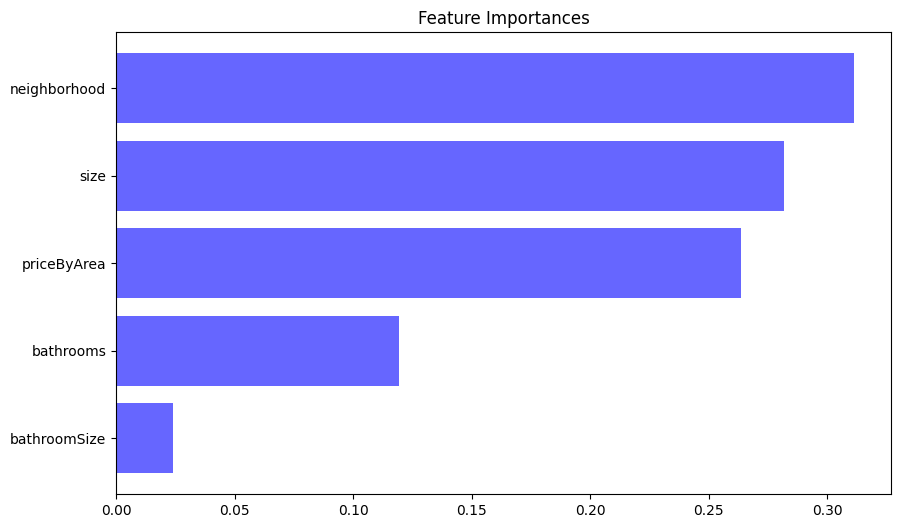

In [637]:
# Obtener importancia de características
feature_names = ['priceByArea', 'size','bathrooms','bathroomSize'] + ['neighborhood']
importances = best_model.named_steps['regressor'].feature_importances_

# Crear un DataFrame para las importancias
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Imprimir las importancias de características
print(feature_importances_df)

# Plot de la importancia de las características
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='blue', alpha=0.6)
plt.gca().invert_yaxis()
plt.show()

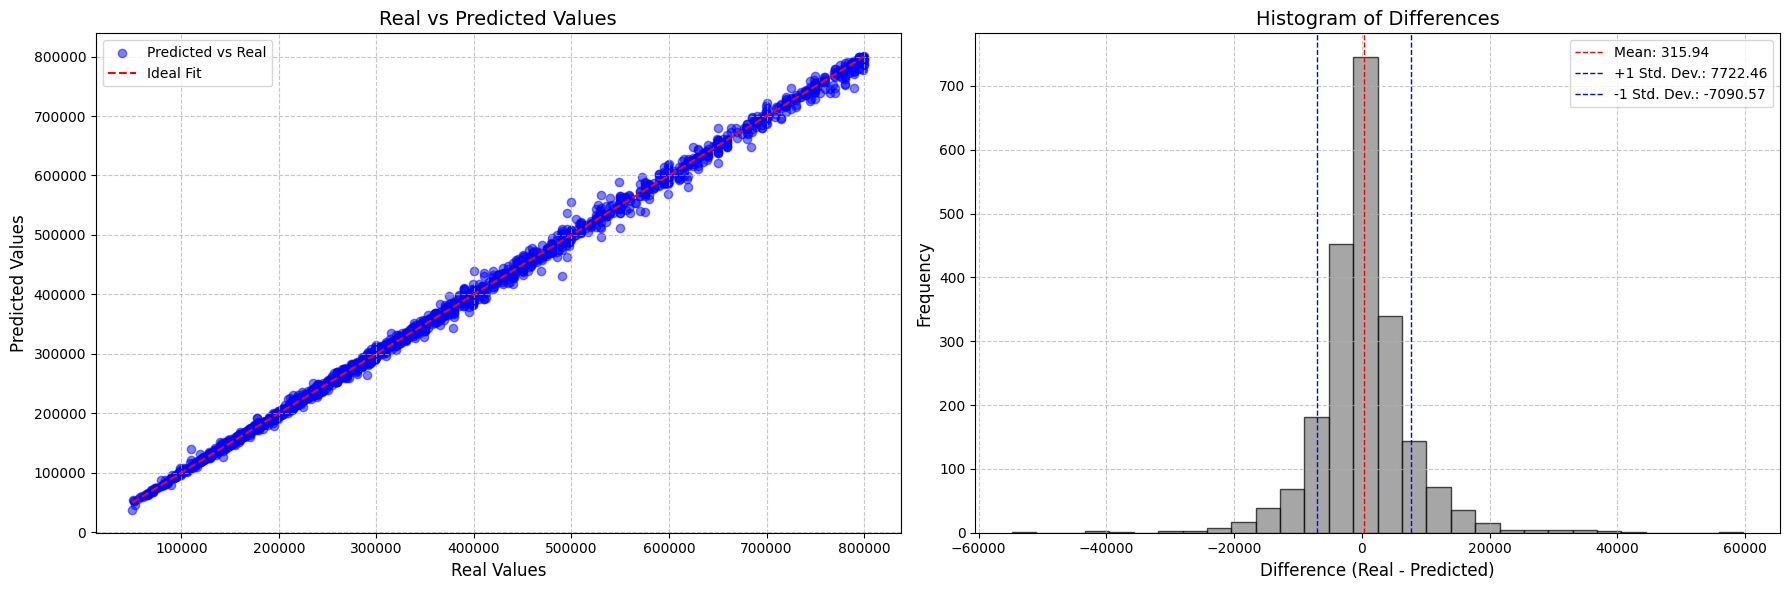

In [639]:
y_pred = feature_importance_merged_df_Difference['Predicted_Price']
y_real = feature_importance_merged_df_Difference['price']
differences = feature_importance_merged_df_Difference['Difference']

# Calcular estadísticas de las diferencias
mean_diff = np.mean(differences)
std_diff = np.std(differences)

# Crear una figura con dos subplots: uno para el scatter plot y otro para el histograma
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Real vs Predicted Values
ax[0].set_title('Real vs Predicted Values', fontsize=14)
ax[0].set_xlabel('Real Values', fontsize=12)
ax[0].set_ylabel('Predicted Values', fontsize=12)
sc = ax[0].scatter(y_real, y_pred, color='blue', alpha=0.5, label='Predicted vs Real')
ax[0].plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--', label='Ideal Fit')
ax[0].legend(loc='upper left')
ax[0].grid(True, linestyle='--', alpha=0.7)

# Subplot 2: Histograma de las diferencias
ax[1].set_title('Histogram of Differences', fontsize=14)
ax[1].set_xlabel('Difference (Real - Predicted)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].hist(differences, bins=30, color='gray', alpha=0.7, edgecolor='black')
ax[1].axvline(mean_diff, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_diff:.2f}')
ax[1].axvline(mean_diff + std_diff, color='blue', linestyle='dashed', linewidth=1, label=f'+1 Std. Dev.: {mean_diff + std_diff:.2f}')
ax[1].axvline(mean_diff - std_diff, color='blue', linestyle='dashed', linewidth=1, label=f'-1 Std. Dev.: {mean_diff - std_diff:.2f}')
ax[1].legend(loc='upper right')
ax[1].grid(True, linestyle='--', alpha=0.7)

# Mostrar la figura
plt.tight_layout()
plt.show()

In [640]:
feature_importance_merged_df_Difference.sort_values(by='Difference',ascending=False).head(15)

,propertyCode,Predicted_Price,price,Difference
2076,104877619,430289.996041,490000.0,59710.003959
920,104555857,746838.126372,790000.0,43161.873628
1604,97008447,580417.843765,620000.0,39582.156235
846,101108633,512155.315809,550000.0,37844.684191
404,100895303,538335.041098,575000.0,36664.958902
1173,104010182,648624.222122,684600.0,35975.777878
1320,104884742,344333.292565,379000.0,34666.707435
838,103966279,496416.100160,530000.0,33583.899840
1570,104395150,462472.923395,495000.0,32527.076605
214,104170446,738799.871061,770000.0,31200.128939


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from category_encoders import TargetEncoder

def tune_gradient_boosting_with_cross_validation(data):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    categorical_transformer = TargetEncoder()

    numeric_features = ['priceByArea', 'floor', 'size', 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 
                        'priceByAreaByDistrict', 'priceByAreaByneighborhood', 'roomSize', 'bathroomSize', 
                        'bathroomRoom', 'liftFloorInteraction']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Define el modelo
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda en cuadrícula
    param_grid = {
        'regressor__n_estimators': [100, 200, 500],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_samples_split': [5, 10, 20],
        'regressor__min_samples_leaf': [2, 5, 10],
        'regressor__subsample': [0.7, 0.85, 1.0]
    }

    # Aplica la búsqueda en cuadrícula de hiperparámetros
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = grid_search.best_estimator_

    # Validación cruzada en el conjunto de entrenamiento
    cv_scores = cross_val_score(best_model, X_train.drop(columns='propertyCode'), y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)

    # Evalúa el modelo en el conjunto de entrenamiento
    y_train_pred = best_model.predict(X_train.drop(columns='propertyCode'))
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    # Evalúa el modelo en el conjunto de validación
    y_valid_pred = best_model.predict(X_valid.drop(columns='propertyCode'))
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    valid_rmse = np.sqrt(valid_mse)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)

    # Calcular la variación
    mse_variation = (valid_mse / train_mse) - 1
    rmse_variation = (valid_rmse / train_rmse) - 1
    mae_variation = (valid_mae / train_mae) - 1

    # Imprimir resultados
    print("Mejores hiperparámetros:", grid_search.best_params_)
    print("\nValidación cruzada (RMSE) en el conjunto de entrenamiento:")
    print(cv_rmse)
    print("\nRendimiento en el conjunto de entrenamiento:")
    print("Mean Squared Error:", train_mse)
    print("Root Mean Squared Error:", train_rmse)
    print("Mean Absolute Error:", train_mae)
    print("\nRendimiento en el conjunto de validación:")
    print("Mean Squared Error:", valid_mse)
    print("Root Mean Squared Error:", valid_rmse)
    print("Mean Absolute Error:", valid_mae)
    print("\nVariación (Validación / Entrenamiento) - 1:")
    print("MSE Variation:", mse_variation)
    print("RMSE Variation:", rmse_variation)
    print("MAE Variation:", mae_variation)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_valid_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    tune_merged_df_Difference_cross_validation = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    tune_merged_df_Difference_cross_validation['Difference'] = tune_merged_df_Difference_cross_validation['price'] - tune_merged_df_Difference_cross_validation['Predicted_Price']

    return best_model, grid_search.best_params_, valid_rmse, valid_mae, tune_merged_df_Difference_cross_validation_cross_validation

# Ejemplo de uso
best_model, best_params, valid_rmse, valid_mae, tune_merged_df_Difference_cross_validation_cross_validation = tune_gradient_boosting_with_cross_validation(feature_engineering_df)

# Imprimir el DataFrame combinado
print(tune_merged_df_Difference_cross_validation_cross_validation.head())


Mejores hiperparámetros: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 20, 'regressor__n_estimators': 500, 'regressor__subsample': 0.7}

Validación cruzada (RMSE) en el conjunto de entrenamiento:
[10079.34696487  8241.58983988 10604.45044291  8301.17330697
  8361.22424461]

Rendimiento en el conjunto de entrenamiento:
Mean Squared Error: 6534147.833970407
Root Mean Squared Error: 2556.197925429564
Mean Absolute Error: 1870.0555753747308

Rendimiento en el conjunto de validación:
Mean Squared Error: 64381593.64400921
Root Mean Squared Error: 8023.814158117647
Mean Absolute Error: 4180.394949821477

Variación (Validación / Entrenamiento) - 1:
MSE Variation: 8.853097187256077
RMSE Variation: 2.1389643494719843
MAE Variation: 1.235438884742123


NameError: name 'tune_merged_df_Difference_cross_validation_cross_validation' is not defined

### Modelo  xgboost 

In [31]:
# Load the data
data = feature_engineering_df[feature_engineering_df['province']=='Madrid']
data = feature_engineering_df[feature_engineering_df['price']<=800000]
# Select target
y =data['price']
melb_predictors = data.drop(['propertyCode','price','Month','province'], axis=1)
X = melb_predictors
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)

print(score_dataset_XGBRegressor_w_OneHotEncoder(X_train, X_valid, y_train, y_valid))
print(score_dataset_XGBRegressor_w_TargetEncoder(X_train, X_valid, y_train, y_valid))

Resultados de Modelo XGBRegressor con OneHotEncoder
Cantidad de valores (8612, 200)
RMSE: 10556.525673384069
MAE: 5970.793569014044

Resultados de Modelo XGBRegressor con TargetEncoder
Cantidad de valores (8612, 23)
RMSE: 11381.298107842162
MAE: 6363.686063718663



### Modelo  xgboost con onehotencoder optimizado con random search

In [50]:
def optimize_xgboost_with_OneHotEncoder(data):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    numeric_features = ['priceByArea', 'floor', 'size', 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 
                        'priceByAreaByDistrict', 'priceByAreaByneighborhood', 'roomSize', 'bathroomSize', 
                        'bathroomRoom', 'liftFloorInteraction']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))])

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'regressor__n_estimators': randint(100, 1000),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__max_depth': randint(3, 10),
        'regressor__min_child_weight': randint(1, 10),
        'regressor__subsample': uniform(0.7, 0.3),
        'regressor__colsample_bytree': uniform(0.7, 0.3)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid.drop(columns='propertyCode'))
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, y_pred)

    # Imprimir resultados
    print("Mejores hiperparámetros:", random_search.best_params_)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    optimize_xgboost_with_OneHotEncoder_df = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    optimize_xgboost_with_OneHotEncoder_df['Difference'] = optimize_xgboost_with_OneHotEncoder_df['price'] - optimize_xgboost_with_OneHotEncoder_df['Predicted_Price']

    return numeric_features,categorical_features,best_model, random_search.best_params_, rmse, mae, optimize_xgboost_with_OneHotEncoder_df

numeric_features,categorical_features,best_model, best_params_xgboost, rmse, mae, optimize_xgboost_with_OneHotEncoder_df = optimize_xgboost_with_OneHotEncoder(feature_engineering_df)

Mejores hiperparámetros: {'regressor__colsample_bytree': 0.7873687420594125, 'regressor__learning_rate': 0.1323705789444759, 'regressor__max_depth': 4, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 975, 'regressor__subsample': 0.8542703315240834}
Mean Squared Error: 101169860.9572842
Root Mean Squared Error: 10058.322969426075
Mean Absolute Error: 5791.390412822076


                        Feature  Importance
4                     bathrooms    0.589931
13    priceByAreaByneighborhood    0.172555
2                          size    0.091204
0                   priceByArea    0.085803
15                 bathroomSize    0.009456
..                          ...         ...
119     neighborhood_La Fortuna    0.000000
123  neighborhood_Leganés norte    0.000000
37          district_La Fortuna    0.000000
39       district_Leganés norte    0.000000
179   neighborhood_V Centenario    0.000000

[199 rows x 2 columns]


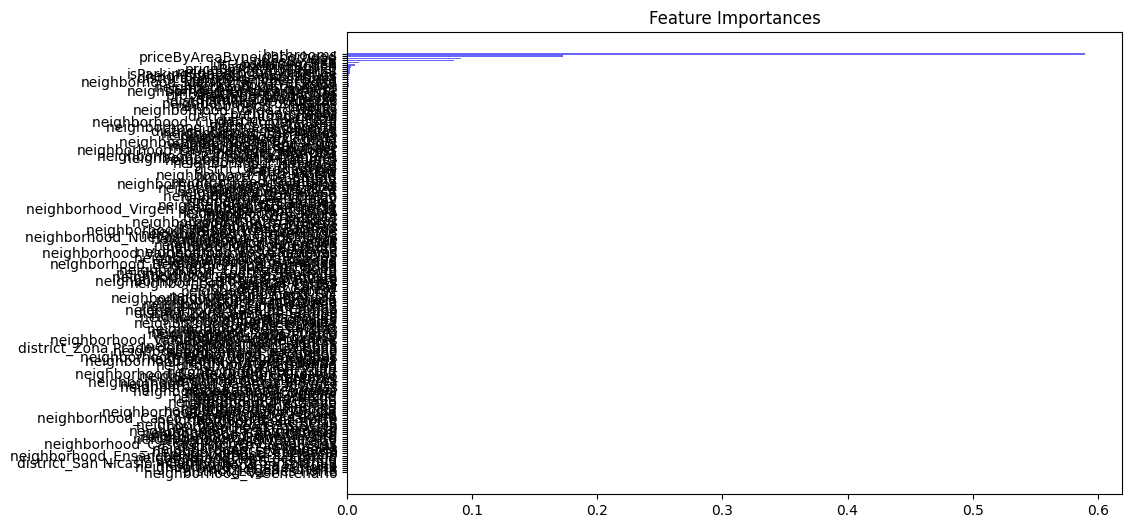

In [51]:
# Obtener importancia de características
# Necesitamos obtener las características después del OneHotEncoder

preprocessor = best_model.named_steps['preprocessor']
encoded_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
all_features = numeric_features + encoded_features
importances = best_model.named_steps['regressor'].feature_importances_

# Crear un DataFrame para las importancias
feature_importances_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Imprimir las importancias de características
print(feature_importances_df)

# Plot de la importancia de las características
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='blue', alpha=0.6)
plt.gca().invert_yaxis()
plt.show()

### Modelo  xgboost con targetencoder optimizado con random search

In [47]:
def optimize_xgboost_with_TargetEncoder(data):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['propertyType', 'status', 'district', 'neighborhood']
    categorical_transformer = TargetEncoder()

    numeric_features = ['priceByArea', 'floor', 'size', 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 
                        'priceByAreaByDistrict', 'priceByAreaByneighborhood', 'roomSize', 'bathroomSize', 
                        'bathroomRoom', 'liftFloorInteraction']
    numeric_transformer = StandardScaler()

    # Aplicar TargetEncoder manualmente a las variables categóricas
    X_train_categorical = categorical_transformer.fit_transform(X_train[categorical_features], y_train)
    X_valid_categorical = categorical_transformer.transform(X_valid[categorical_features])

    # Aplicar transformaciones numéricas
    X_train_numeric = numeric_transformer.fit_transform(X_train[numeric_features])
    X_valid_numeric = numeric_transformer.transform(X_valid[numeric_features])

    # Combinar características transformadas
    X_train_transformed = np.hstack((X_train_numeric, X_train_categorical))
    X_valid_transformed = np.hstack((X_valid_numeric, X_valid_categorical))

    # Combina preprocesamiento y modelo en un pipeline
    model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'n_estimators': randint(100, 1000),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 10),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train_transformed, y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid_transformed)
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, y_pred)

    # Imprimir resultados
    print("Mejores hiperparámetros:", random_search.best_params_)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    best_params_xgboost_target_encoder_df = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    best_params_xgboost_target_encoder_df['Difference'] = best_params_xgboost_target_encoder_df['price'] - best_params_xgboost_target_encoder_df['Predicted_Price']

    return numeric_features, categorical_features, best_model, random_search.best_params_, rmse, mae, best_params_xgboost_target_encoder_df

numeric_features, categorical_features,best_model, best_params_xgboost_target_encoder, rmse, mae, optimize_xgboost_with_OneHotEncoder_df = optimize_xgboost_with_TargetEncoder(feature_engineering_df)

Mejores hiperparámetros: {'colsample_bytree': 0.7873687420594125, 'learning_rate': 0.1323705789444759, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 975, 'subsample': 0.8542703315240834}
Mean Squared Error: 126513107.394817
Root Mean Squared Error: 11247.804558882457
Mean Absolute Error: 6625.503182668872


                          Feature  Importance
4                       bathrooms    0.402706
21                   neighborhood    0.283114
2                            size    0.082790
0                     priceByArea    0.068797
3                           rooms    0.064085
15                   bathroomSize    0.023140
13      priceByAreaByneighborhood    0.019948
14                       roomSize    0.017120
9                 hasParkingSpace    0.011401
17           liftFloorInteraction    0.009340
20                       district    0.003833
8                         hasLift    0.003490
18                   propertyType    0.003425
12          priceByAreaByDistrict    0.002270
19                         status    0.001511
16                   bathroomRoom    0.000800
5                        distance    0.000720
1                           floor    0.000388
10  isParkingSpaceIncludedInPrice    0.000347
6                        latitude    0.000341
7                       longitude 

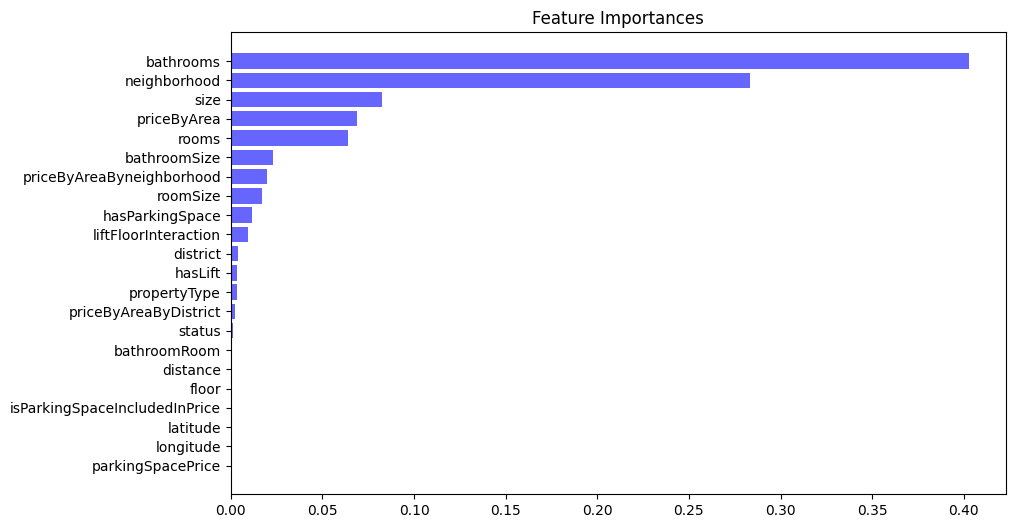

In [48]:
# Obtener importancia de características
feature_names = numeric_features + categorical_features
importances = best_model.feature_importances_

# Crear un DataFrame para las importancias
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Imprimir las importancias de características
print(feature_importances_df)

# Plot de la importancia de las características
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='blue', alpha=0.6)
plt.gca().invert_yaxis()
plt.show()

In [58]:
def optimize_xgboost_with_TargetEncoder_feature_importances(data):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province','longitude','latitude','distance',
                    'floor','district','liftFloorInteraction','priceByAreaByDistrict',
                    'bathroomRoom','parkingSpacePrice','propertyType','status','isParkingSpaceIncludedInPrice',
                    'hasParkingSpace','hasLift'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['neighborhood']
    categorical_transformer = TargetEncoder()
    
    numeric_features = ['bathrooms','size','priceByArea','rooms','bathroomSize','priceByAreaByneighborhood','roomSize']
    numeric_transformer = StandardScaler()

    # Aplicar TargetEncoder manualmente a las variables categóricas
    X_train_categorical = categorical_transformer.fit_transform(X_train[categorical_features], y_train)
    X_valid_categorical = categorical_transformer.transform(X_valid[categorical_features])

    # Aplicar transformaciones numéricas
    X_train_numeric = numeric_transformer.fit_transform(X_train[numeric_features])
    X_valid_numeric = numeric_transformer.transform(X_valid[numeric_features])

    # Combinar características transformadas
    X_train_transformed = np.hstack((X_train_numeric, X_train_categorical))
    X_valid_transformed = np.hstack((X_valid_numeric, X_valid_categorical))

    # Combina preprocesamiento y modelo en un pipeline
    model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'n_estimators': randint(100, 1000),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 10),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train_transformed, y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid_transformed)
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, y_pred)

    # Imprimir resultados
    print("Mejores hiperparámetros:", random_search.best_params_)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    best_params_xgboost_target_encoder_df_feature_importances = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    best_params_xgboost_target_encoder_df_feature_importances['Difference'] = best_params_xgboost_target_encoder_df_feature_importances['price'] - best_params_xgboost_target_encoder_df_feature_importances['Predicted_Price']

    return numeric_features, categorical_features, best_model, random_search.best_params_, rmse, mae, best_params_xgboost_target_encoder_df_feature_importances

numeric_features, categorical_features,best_model, best_params_xgboost_target_encoder, rmse, mae, best_params_xgboost_target_encoder_df_feature_importances = optimize_xgboost_with_TargetEncoder_feature_importances(feature_engineering_df)

Mejores hiperparámetros: {'colsample_bytree': 0.7873687420594125, 'learning_rate': 0.1323705789444759, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 975, 'subsample': 0.8542703315240834}
Mean Squared Error: 92101449.60535182
Root Mean Squared Error: 9596.950015778546
Mean Absolute Error: 5436.3545112291085


                     Feature  Importance
0                  bathrooms    0.459282
7               neighborhood    0.256492
1                       size    0.128373
2                priceByArea    0.101568
5  priceByAreaByneighborhood    0.024739
4               bathroomSize    0.013825
3                      rooms    0.011450
6                   roomSize    0.004273


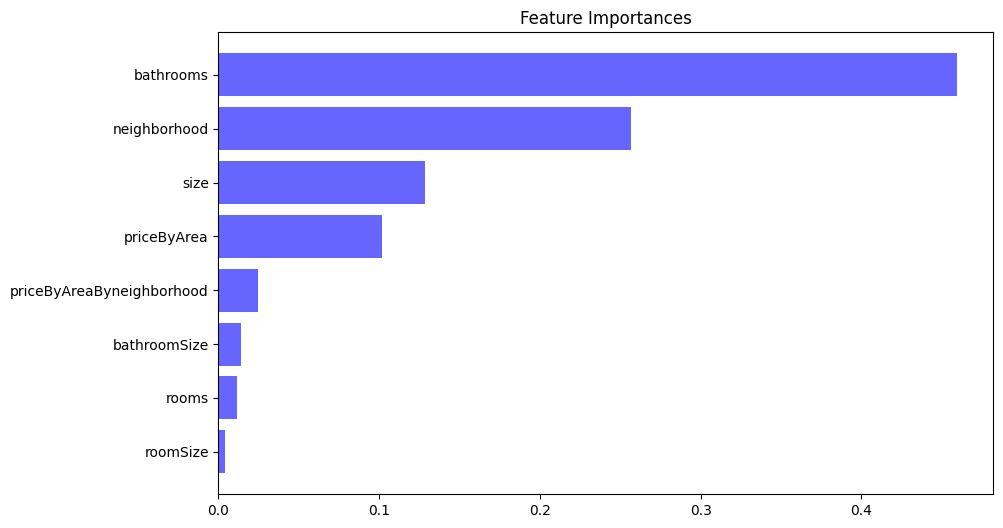

In [59]:
# Obtener importancia de características
feature_names = numeric_features + categorical_features
importances = best_model.feature_importances_

# Crear un DataFrame para las importancias
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Imprimir las importancias de características
print(feature_importances_df)

# Plot de la importancia de las características
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='blue', alpha=0.6)
plt.gca().invert_yaxis()
plt.show()